# Capstone Project: Board Games Recommender
____________

# Part 1a - EDA & Cleaning of Board Games Data

### Riche Ngo, SG-DSI-18

## Introduction

[Board games](https://en.wikipedia.org/wiki/Board_game) are traditionally a subset of [tabletop games](https://en.wikipedia.org/wiki/Tabletop_game) that involve counters or pieces moved or placed on a pre-marked surface or board, according to a set of rules. While ancient board games like [Senet](https://en.wikipedia.org/wiki/Senet) and [Mehen](https://en.wikipedia.org/wiki/Mehen) existed when paper was invented, it was the 20th century that board games began to evolve dynamically in different directions. The two largest markets back then were the United States (US) and Germany, featuring two different broad categories of board games. In the US was where you could find [Ameritrash](https://en.wikipedia.org/wiki/Amerigame) games, devoted more towards [role-playing](https://en.wikipedia.org/wiki/Role-playing) games, often simulating warfare and adventure themes. On the other hand, [Eurogames](https://en.wikipedia.org/wiki/Eurogame) were developed by Germany, usually placing focus on the mechanics of the game and involving proper strategy. Several other board game genres have since appeared, such as [deckbuilders](https://en.wikipedia.org/wiki/Deck-building_game), [dexterity games](http://www.boardgamizer.com/mechanics/definition/dexterity), [roll-and-write games](http://sgl.la/blog/2018/4/27/what-is-a-roll-and-write-game), etc. In recent years, many board games comprise multiple game types, also taking elements of Ameritrash games while utilizing mechanics typical of Eurogames.

The global board games market size was worth an [estimated USD 13.1 Billion in 2019](https://blog.pipecandy.com/board-games-market/), and is expected to grow constantly. Another source forecasted that the board games market would reach [USD 30 Billion by 2026](https://www.arizton.com/market-reports/global-board-games-market-industry-analysis-2024), due to increasing popularity and acceptance among people despite the competition from digital entertainment sources. Living in the age of the internet, many board game blogs, forums, content creators surfaced and this will drive the board games market to become even larger.

## Problem Statement

Given the large growing board game community, more people are seeking for good methods to find their ideal board game. The newer, modern board games do not come cheap as the demand for good production value and immersive experiences in games increases. It is always a good idea to do some research on a particular board game before making the purchase. Commonly, people will use forums such as [BoardGameGeek](https://boardgamegeek.com/) and [Reddit](https://www.reddit.com/) to look for game recommendations. Some people turn to channels on [Youtube](https://www.youtube.com/) hosted by groups such as [Dice Tower](https://www.dicetower.com/) and [Watch It Played](https://en.wikipedia.org/wiki/Watch_It_Played) for video reviews on board games. However, more often than not, these outlets would suggest the same popular board games in the community, and it would almost never be personalized to each individual.

As part of a data science team affiliated to the major board game forum BoardGameGeek (BGG), we want to build a good board game recommender system to reduce user churn, increase the time spent on the website, and attract new users to the BGG community. We want to focus on building a great user experience when people use the recommender system and concentrate on giving personalized recommendations to each and every user.

## Executive Summary

This project explores data collected from the BoardGameGeek (BGG) website, comprising all information about the board games and the ratings given by users of the BGG community. We analyzed, dealt with missing values, and cleaned the datasets before using their features to build the recommender system.

The data consisted of information for over 90,000 board games listed on the website. Because quite a number of features had values contributed by the BGG community, the dataset contained a large percentage of missing values. Considering that and the relevance of each board game, we sieved out the older and unpopular board games. We uncovered many interesting things about the data, such as games listed with long playing times like [Risk](https://en.wikipedia.org/wiki/Risk_(game)) usually carry the theme of warfare or battle.

Through analysis, we saw that the number of board game publications had a steady increase from the Year 1995, and shot up further since the launch of [Kickstarter](https://www.kickstarter.com/) in 2009. Although the number of user ratings followed a similar trend, we observed a cyclical pattern, where the number of ratings generally plunges towards the mid of each year, then rises quickly nearing the end of each year. In addition, a large proportion of the board games are strategy games, involve cards, with dice rolling and/or hand management mechanics. We discovered that BGG uses a hidden formula to calculate a ["Geek Rating"](https://boardgamegeek.com/thread/1702432/what-geek-rating) which determines the ranking of each board game. Since it is a good indicator of popularity, we chose to trim the dataset down to games within the first 10,000 ranks. Exploring further, we found that the interquartile range of user ratings between 6.0 and 8.0 (inclusive), 7.0 being the median (on a scale of 1.0 to 10.0). 

We built several recommender systems, adopting a range of techniques including matrix factorization and dimensionality reduction. After evaluating each one, the final recommender system which found to give the best results was built with an amalgamation of two systems. The first is a collaborative filtering system which locates a set of users in the BGG community who have similar board game preferences with the current user. The set of similar users would go through a deep neural network with trained entity embedding layers to detect similarities between user ratings and multiple board game features. The output would be a mutable list of recommendations.

A total of 9 broad topics were discovered after building a topic model based on the descriptions of the board games. This came in useful after we deployed the final recommender system in a web application using `Streamlit`. Users were given an option to diversify their already personalized recommendations based on the identified topics, allowing them to see a wider variety of board game recommendations. On top of that, many filtering options (such as by publication year, game complexity) were given to the user to further personalize their board game recommendations.

### Contents:
- [Cleaning & EDA](#Cleaning-&-EDA)
- [Turther EDA](#Further-EDA)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json_lines
import pickle
import urllib

# Images
import cv2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Data Dictionary

| Feature | Description |
|-|-|
| bgg_id | Board game's ID on BoardGameGeek database. |
| name | Board game's name in English. |
| year | Board game's year of release. |
| game_type | Board game's associated game types (e.g. strategy game, thematic, etc.). |
| designer | Designer(s) of the board game. |
| artist | Artist(s) of the board game and its components. |
| publisher | Publisher(s) of the board game. |
| min_players | Minimum number of players for the board game by design. |
| max_players | Maximum number of players for the board game by design. |
| min_players_rec | Minimum number of players for the board game as recommended by the BGG community. |
| max_players_rec | Maximum number of players for the board game as recommended by the BGG community. |
| min_players_best | Best number of players minimally for the board game as suggested by the BGG community. |
| max_players_best | Best maximum number of players for the board game as suggested by the BGG community. |
| min_age | Minimum age for players to play the board game by design. |
| min_age_rec | Minimum age for players to play the board game as recommended by the BGG community. |
| min_time | Minimum time required for a single play-through of the board game as stated by the designer. |
| max_time | Maximum time required for a single play-through of the board game as stated by the designer. |
| category | Board game's associated categories (e.g. Adventure, Exploration, Fantasy, etc.). |
| mechanic | Board game's associated mechanics (e.g. Chaining, Drafting, Push Your Luck, etc.). |
| cooperative | Whether the board game has cooperative game play (0 means non-cooperative, 1 means cooperative). |
| compilation | Whether the board game is a compilation of others (0 means not compilation, 1 means compilation). |
| compilation_of | The set of items which the board game is a compilation of. |
| family | The broad families which the board game falls into (e.g. Two Player Only Games, Theme: Tropical Islands, etc.). |
| implementation | The bgg_id of the previous board game which this one is a re-implementation of. |
| integration | The bgg_id of another board game which this one integrates with. |
| rank | Board game's overall ranking on the BGG website. |
| num_votes | Total number of votes on rating the board game by the BGG community. |
| avg_rating | Board game's average rating given by the BGG community (On a scale of 1-10, 10 being the best while 1 being the worst). |
| stddev_rating | Standard deviation of board game's rating given by the BGG community. |
| bayes_rating | Board game's average rating using the Bayesian method.  |
| complexity | Board game's average rating for how difficult the game is to understand, by the BGG community (On a scale of 1-5, the lower the rating, the easier the game is to understand). |
| language_dependency | How language-dependent components (aside from the rules) are for those who do not speak the game published language (On a scale of 1-5, 5 means no necessary in-game text, 1 means unplayable in another language). |
| _id | Board game's associated ID with other websites (like BGA, WikiData, etc.). |

### Import data

The dataset was obtained from Markus Shepherd, who created a [board game scraper](https://gitlab.com/recommend.games/board-game-scraper) for several major board game websites. We will be using data scraped from [BoardGameGeek](https://boardgamegeek.com/), an online forum for board gaming hobbyists and a game database. The website's database covers over 90,000 game titles as of January 2021.

In [2]:
# Import data
df = pd.read_csv('../datasets/boardgames/scraped_bgg_GameItem.csv')

C:\Users\riche\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 100)

In [4]:
df.shape

(98920, 38)

In [5]:
df.head(10)

bgg_id                name    year game_type designer       artist  \
0       1          Die Macher  1986.0      5497        1   12517,4959   
1       2        Dragonmaster  1981.0      5497     8384        12424   
2       3             Samurai  1998.0      5497        2        11883   
3       4      Tal der Könige  1992.0       NaN     8008         2277   
4       5             Acquire  1964.0      5497        4  12658,18317   
5       6  Mare Mediterraneum  1989.0       NaN        5            5   
6       7           Cathedral  1978.0      4666     1335        36624   
7       8   Lords of Creation  1993.0       NaN        6        36807   
8       9        El Caballero  1998.0      5497      7,8           74   
9      10           Elfenland  1998.0      5499        9           74   

                                                                   publisher  \
0                                     133,2,2726,15108,39249,11652,5382,8147   
1                                                                      64,20   
2  17,133,267,29,7340,7335,41,2973,4617,1391,8291,5812,3218,3,3954,8313,8759   
3                                                                         37   
4                             92,5,4871,3082,858,2962,5392,4668,38,4622,7107   
5                                                                          6   
6                               6421,4089,672,786,155,148,327,93,17832,35425   
7                                                                     4675,7   
8                                                                  267,133,3   
9                                                    8,267,6818,18852,3395,3   

   min_players  max_players  min_players_rec  max_players_rec  \
0          3.0          5.0              4.0              5.0   
1          3.0          4.0              3.0              4.0   
2          2.0          4.0              2.0              4.0   
3          2.0          4.0              2.0              4.0   
4          2.0          6.0              3.0              6.0   
5          2.0          6.0              2.0              6.0   
6          2.0          2.0              2.0              2.0   
7          2.0          5.0              2.0              5.0   
8          2.0          4.0              2.0              4.0   
9          2.0          6.0              3.0              6.0   

   min_players_best  max_players_best  min_age  min_age_rec  min_time  \
0               5.0               5.0     14.0    14.031250     240.0   
1               3.0               4.0     12.0          NaN      30.0   
2               3.0               3.0     10.0     9.793103      30.0   
3               2.0               4.0     12.0          NaN      60.0   
4               4.0               4.0     12.0    11.735294      90.0   
5               2.0               6.0     12.0          NaN     240.0   
6               2.0               2.0      8.0          NaN      20.0   
7               2.0               5.0     12.0          NaN     120.0   
8               2.0               4.0     13.0          NaN      90.0   
9               4.0               4.0     10.0     8.117647      60.0   

   max_time        category                                 mechanic  \
0     240.0  1021,1026,1001            2916,2080,2012,2072,2040,2020   
1      30.0       1002,1010                                     2009   
2      60.0       1009,1035            2080,2040,2026,2846,2004,2002   
3      60.0            1050                      2001,2080,2012,2004   
4      90.0            1021  2040,2910,2900,2911,2940,2005,2002,2874   
5     240.0       1015,1008                                     2072   
6      20.0            1009                      2043,2048,2060,2002   
7     120.0       1015,1010                                     2011   
8      90.0            1020                                2080,2002   
9      60.0       1010,1097                      2041,2040,2081,2078   

   co

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98920 entries, 0 to 98919
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bgg_id               98920 non-null  int64  
 1   name                 98920 non-null  object 
 2   year                 89905 non-null  float64
 3   game_type            21581 non-null  object 
 4   designer             84614 non-null  object 
 5   artist               40245 non-null  object 
 6   publisher            98910 non-null  object 
 7   min_players          97086 non-null  float64
 8   max_players          93550 non-null  float64
 9   min_players_rec      97086 non-null  float64
 10  max_players_rec      93550 non-null  float64
 11  min_players_best     97086 non-null  float64
 12  max_players_best     93550 non-null  float64
 13  min_age              76949 non-null  float64
 14  min_age_rec          887 non-null    float64
 15  min_time             78242 non-null 

The items such as game_type, artist, publisher, etc. are all coded by their ids. There is no meaning to these numbers if we are unable to explain it when we do EDA.

We want to extract the descriptions for these coded items from the scraped data `.jl` file.

In [7]:
# Read 10 lines of the .jl file to see what we are dealing with
with open('../datasets/boardgames/scraped_bgg_GameItem.jl', 'rb') as f:
    count = 1
    for item in json_lines.reader(f):
        print(count, item)
        print('\n\n\n-----------------------')
        count += 1
        if count == 10:
            break

1 {'add_rank': [{'bayes_rating': 7.27122, 'game_type': 'strategygames', 'game_type_id': 5497, 'name': 'Strategy Game', 'rank': 156}], 'alt_name': ['Die Macher', '德国大选', '디 마허'], 'artist': ['Marcus Gschwendtner:12517', 'Harald Lieske:4959'], 'avg_rating': 7.6308, 'bayes_rating': 7.14289, 'best_rating': 10, 'bgg_id': 1, 'category': ['Economic:1021', 'Negotiation:1026', 'Political:1001'], 'compilation': False, 'complexity': 4.3245, 'cooperative': False, 'description': 'Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regio

In [110]:
# Extract image urls
image_dict = {}

with open('../datasets/boardgames/scraped_bgg_GameItem.jl', 'rb') as f:
    for item in json_lines.reader(f):
        try:
            image_dict[item['bgg_id']] = str(item['image_url'][0])
        except:
            continue

In [111]:
# Extract descriptions for coded items
game_type_dict = {}
designer_dict = {}
artist_dict = {}
publisher_dict = {}
category_dict = {}
mechanic_dict = {}


with open('../datasets/boardgames/scraped_bgg_GameItem.jl', 'rb') as f:
    for item in json_lines.reader(f):
        try:
            for i in range(len(item['add_rank'])):
                game_type_dict[str(item['add_rank'][i]['game_type_id'])] = item['add_rank'][i]['game_type']
        
            for j in range(len(item['designer'])):
                designer_split = item['designer'][j].split(':')
                designer_dict[str(designer_split[1])] = designer_split[0]

            for k in range(len(item['artist'])):
                artist_split = item['artist'][k].split(':')
                artist_dict[str(artist_split[1])] = artist_split[0]

            for l in range(len(item['publisher'])):
                publisher_split = item['publisher'][l].split(':')
                publisher_dict[str(publisher_split[1])] = publisher_split[0]

            for c in range(len(item['category'])):
                category_split = item['category'][c].split(':')
                last = len(category_split) - 1
                category_dict[str(category_split[last])] = category_split[0]

            for m in range(len(item['mechanic'])):
                mechanic_split = item['mechanic'][m].split(':')
                last = len(mechanic_split) - 1
                mechanic_dict[str(mechanic_split[last])] = mechanic_split[0]
            
            
        except:
            continue
            
ref_dicts = {'game_types': game_type_dict,
            'designers': designer_dict,
            'artists': artist_dict,
            'publishers': publisher_dict,
            'categories': category_dict,
            'mechanics': mechanic_dict,
            'images': image_dict}

In [10]:
# Check the length of each dictionary
for k, v in ref_dicts.items():
    print(f'No. of {k}: {len(v)}')

No. of game_types: 12
No. of designers: 8458
No. of artists: 7823
No. of publishers: 4462
No. of categories: 83
No. of mechanics: 182
No. of images: 90245


In [11]:
# Check single entry
df.loc[df['name']=='Gloomhaven']

bgg_id        name    year  game_type designer             artist  \
66096  174430  Gloomhaven  2017.0  5496,5497    69802  77084,78961,84269   

                                                          publisher  \
66096  27425,4304,46179,157,22380,15605,40478,8820,18852,8291,23756   

       min_players  max_players  min_players_rec  max_players_rec  \
66096          1.0          4.0              1.0              4.0   

       min_players_best  max_players_best  min_age  min_age_rec  min_time  \
66096               3.0               3.0     14.0    13.566964      60.0   

       max_time                  category  \
66096     120.0  1022,1020,1010,1046,1047   

                                                                                             mechanic  \
66096  2689,2839,2018,2857,2893,2023,3004,2664,2676,2040,2026,2824,2011,2846,2822,2020,2819,2027,2015   

       cooperative  compilation compilation_of  \
66096            1            0            NaN   

                                              family implementation  \
66096  59218,25158,65191,8374,45610,24281,25404,5666            NaN   

         integration  rank  num_votes  avg_rating  stddev_rating  \
66096  295770,291457   1.0    40523.0     8.80123        1.61052   

       bayes_rating  complexity  language_dependency  bga_id  dbpedia_id  \
66096       8.55722      3.8515             4.131579     NaN         NaN   

       luding_id  spielen_id  wikidata_id  wikipedia_id  
66096        NaN         NaN          NaN           NaN

In [12]:
# Check game types for this board game
game_types = df.loc[df['name']=='Gloomhaven', 'game_type'].values
game_types = game_types[0].split(',')
print('Game Types\n------------')
for type_id in game_types:
    print(game_type_dict[type_id])

Game Types
------------
thematic
strategygames


In [13]:
# Check categories for this board game
categories = df.loc[df['name']=='Gloomhaven', 'category'].values
categories = categories[0].split(',')
print('Categories\n------------')
for c_id in categories:
    print(category_dict[c_id])

Categories
------------
Adventure
Exploration
Fantasy
Fighting
Miniatures


In [14]:
# Check mechanics for this board game
mechanics = df.loc[df['name']=='Gloomhaven', 'mechanic'].values
mechanics = mechanics[0].split(',')
print('Mechanics\n------------')
for c_id in mechanics:
    print(mechanic_dict[c_id])

Mechanics
------------
Action Queue
Action Retrieval
Campaign / Battle Card Driven
Card Play Conflict Resolution
Communication Limits
Cooperative Game
Deck Construction
Deck, Bag, and Pool Building
Grid Movement
Hand Management
Hexagon Grid
Legacy Game
Modular Board
Once-Per-Game Abilities
Scenario / Mission / Campaign Game
Simultaneous Action Selection
Solo / Solitaire Game
Storytelling
Variable Player Powers


## Cleaning & EDA

First and formost, we are not really concerned with the associated IDs for each board game with the other websites since our recommendation system will be built only on BGG's dataset.

In [15]:
# Remove the columns for other website ids
df.drop(columns=['bga_id', 'dbpedia_id', 'luding_id', 'spielen_id', 'wikidata_id', 'wikipedia_id'], inplace=True)

In [16]:
# Study value_counts of compilation
df['compilation'].value_counts()

0    98260
1      660
Name: compilation, dtype: int64

We find that the "compilation" feature is not very variable across the dataset (large proportion of data consists of a single type). Based on domain knowledge, board gamers would not choose to play a board game based on whether it is a compilation or not. As such, we will go ahead and drop the features related to compilation.

In [17]:
# Drop compilation features
df.drop(columns=['compilation', 'compilation_of'], inplace=True)

In [18]:
# Decribe the numerical features
df.describe().T

count           mean            std          min  \
bgg_id               98920.0  125711.297311  102984.529331     1.000000   
year                 89905.0    1999.257894      72.312353 -3500.000000   
min_players          97086.0       2.039347       0.815401     1.000000   
max_players          93550.0       6.587664      52.894354     1.000000   
min_players_rec      97086.0       2.044466       0.821074     1.000000   
max_players_rec      93550.0       6.569022      52.883598     1.000000   
min_players_best     97086.0       2.075809       0.858933     1.000000   
max_players_best     93550.0       6.546104      52.884310     1.000000   
min_age              76949.0       9.392650       3.336752     1.000000   
min_age_rec            887.0       9.887589       2.828770     2.025641   
min_time             78242.0      53.328954     654.427860     1.000000   
max_time             78242.0     494.776335  107547.560343     1.000000   
cooperative          98920.0       0.048484       0.214787     0.000000   
rank                 20019.0   10010.789000    5779.658812     1.000000   
num_votes            98919.0     173.140135    1593.979538     0.000000   
avg_rating           72845.0       5.998800       1.621164     1.000000   
stddev_rating        98919.0       0.861196       0.860366     0.000000   
bayes_rating         20303.0       5.689566       0.368874     3.538020   
complexity           42874.0       1.926551       0.844780     1.000000   
language_dependency    777.0       2.103864       1.196665     1.000000   

                              25%            50%            75%           max  
bgg_id               28409.750000  111583.500000  210900.250000  3.283260e+05  
year                  1995.000000    2008.000000    2016.000000  2.023000e+03  
min_players              2.000000       2.000000       2.000000  5.000000e+01  
max_players              4.000000       4.000000       6.000000  1.129900e+04  
min_players_rec          2.000000       2.000000       2.000000  5.000000e+01  
max_players_rec          4.000000       4.000000       6.000000  1.129900e+04  
min_players_best         2.000000       2.000000       2.000000  5.000000e+01  
max_players_best         3.000000       4.000000       6.000000  1.129900e+04  
min_age                  7.000000      10.000000      12.000000  1.120000e+02  
min_age_rec              8.000000      10.000000      11.957428  2.054167e+01  
min_time                20.000000      30.000000      60.000000  1.576800e+05  
max_time                20.000000      30.000000      60.000000  3.000000e+07  
cooperative              0.000000       0.000000       0.000000  1.000000e+00  
rank                  5000.500000   10009.000000   14999.500000  2.002500e+04  
num_votes                0.000000       3.000000      18.000000  1.002190e+05  
avg_rating               5.000000       6.038660       7.000000  1.000000e+01  
stddev_rating            0.000000       0.932018       1.501470  4.500000e+00  
bayes_rating             5.510940       5.549700       5.687715  8.557220e+00  
complexity               1.000000       2.000000       2.500000  5.000000e+00  
language_dependency      1.011628       1.733333       3.053333  4.983333e+00

We noticed that the "year" feature contains negative values and also have the maximum value at 2023, which is the future. We also see some potential anomalies in features such as "min_players", "max_players", "min_age", "min_time" and "max_time" where the maximum values seem way too high for any board game. We want to investigate this further.

In [19]:
# Board games with negative year values
neg_yr = df.loc[df['year']<=0]
neg_yr

bgg_id                                      name    year  game_type  \
168       188                                        Go -2200.0       4666   
1366     1602                      The Royal Game of Ur -2600.0       4666   
2057     2397                                Backgammon -3000.0       4666   
2059     2399                                     Senet -3500.0       4666   
2495     2912  Hounds and Jackals: Game of the Pharaohs -2000.0        NaN   
3359     3886                         Nine Men's Morris -1400.0       4666   
3591     4148                                     Mehen -3000.0       4666   
4715     5432                        Chutes and Ladders  -200.0       4665   
4812     5546                                   Marbles -3000.0       4665   
10285   11726                              Knucklebones -3000.0        NaN   
10440   11901                               Tic-Tac-Toe -1300.0  4665,4666   
12079   13776                                 Ashtapada  -350.0       4666   
17407   19915                        Three Men's Morris -1400.0       4666   
18712   21488                                   Petteia  -100.0       4666   
19675   22610                                     Liubo  -700.0       4666   
20177   23211                                20 Squares -3000.0        NaN   
22360   25702                          Six Men's Morris -1400.0       4666   
24479   28128                                   Pah Tum -1800.0       4666   
32797   37701                               Five Stones -2000.0        NaN   
34424   39628                                    Jiroft -2500.0        NaN   
35103   40412                                   Fan Tan  -600.0        NaN   
67969  180952                        Seven Men's Morris -1400.0        NaN   

      designer  \
168          3   
1366         3   
2057         3   
2059         3   
2495         3   
3359         3   
3591         3   
4715         3   
4812         3   
10285        3   
10440        3   
12079        3   
17407        3   
18712    11064   
19675        3   
20177        3   
22360        3   
24479        3   
32797        3   
34424        3   
35103        3   
67969        3   

                                                                                         artist  \
168                                                                               3,33954,70252   
1366                                                                                     109537   
2057                                                                                    3,26868   
2059                                                                         64922,128192,79195   
2495                                                                                        NaN   
3359                                                                               109537,60765   
3591                                                                                        NaN   
4715   3,52810,71033,8810,63030,10171,6710,9988,15382,67073,31486,68337,72155,50679,12734,51657   
4812                                                                                        NaN   
10285                                                                                       NaN   
10440                                                                                       NaN   
12079                                                                                       NaN   
17407                                                                                       NaN   
18712                                                                                      9393   
19675                                                                                       NaN   
20177                                                                                       NaN   
22360                                                                                       NaN   
24479          

In [107]:
# Function to read image urls
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # return the image
    return cv2.resize(image, (2000,2000))

# Function to plot images
def subplot_images(image_urls, name_list):
    nrows = int(np.ceil(len(name_list)/4))   # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(16, nrows*4), sharex=True, sharey=True)   
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, img_url in enumerate(image_urls):   # Gives us an index value to get into all our lists
        image = url_to_image(img_url)
        ax[i].imshow(image)
        ax[i].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        txt = ax[i].text(100, 1850, name_list[i], wrap=True, ha='left', size=14, family='Arial',
                   bbox=dict(boxstyle="square",
                             ec='lightgrey',
                             fc='lightgrey',
                             alpha=0.9
                   ))
        txt._get_wrap_line_width = lambda : 180
        
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(name_list):]:
        axes.axis('off')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    pass

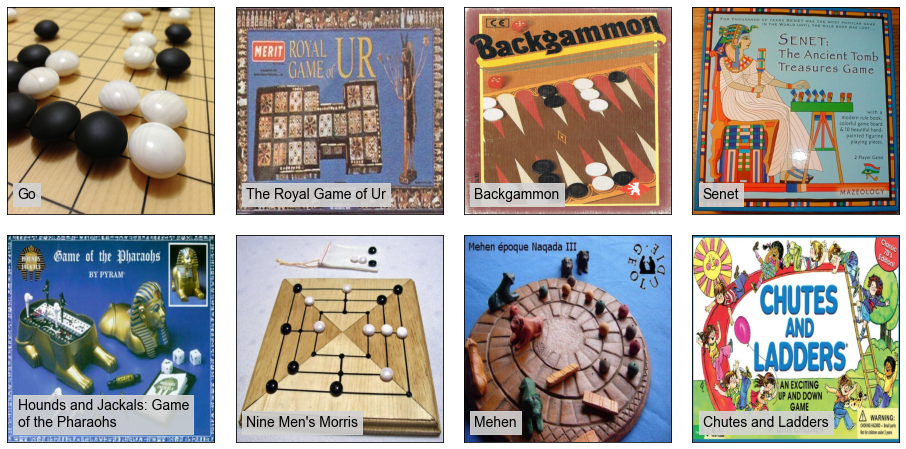

In [112]:
# Illustrate 8 of these games
neg_yr_id = neg_yr['bgg_id'].values[:8]
neg_yr_imgs = [ref_dicts['images'][i] for i in neg_yr_id]
subplot_images(neg_yr_imgs, neg_yr['name'].values[:8])

Looking further into each of these games, we found that these are mostly traditional board games that are dated. We are not trying to recommend such board games. As such, these games will be removed from our dataframe. 

On that note, we also found out that there were still many traditional board games in the dataframe. The board gaming market experienced significant growth from the late 1990s [[source](https://en.wikipedia.org/wiki/Board_game)]. "The Settlers of Catan" was one of the first Eurogames to achieve popularity outside of Europe. Therefore, we will filter our board games dated before the Year 1995.

In [23]:
# Remove dated board games from dataframe
df = df.loc[df['year']>=1995]

In [24]:
# Taking a look at some of the board games of year 2021 and beyond
future_yr = df.loc[df['year']>=2021]
print(f'There are {future_yr.shape[0]} such games.')
future_yr.sample(20, random_state=42)

There are 1137 such games.


bgg_id                                                    name    year  \
97373  321979                                                 Chirpee  2021.0   
97899  323887                                                Van Gogh  2021.0   
92046  299058                                             Flight Time  2021.0   
98652  326934                               Unmatched: Hell's Kitchen  2021.0   
93049  302679                              Stormsunder: Heirs of Ruin  2022.0   
86283  271601                                         Feed the Kraken  2021.0   
95633  314393                                                  Wutaki  2021.0   
82204  253512                                                  Blabel  2021.0   
97908  323947        Middara: Unintentional Malum – Act 1 Version 1.1  2021.0   
90994  294702                                             Theme Parks  2021.0   
97243  321335                                           Age of Trains  2021.0   
84973  265436                                         Cute AlieNation  2021.0   
97089  320862                                       Save Patient Zero  2021.0   
97267  321518                                                Vendarla  2021.0   
98044  324554                                        Monster Marathon  2021.0   
97953  324132                       Be The Greatest Soccer Board Game  2021.0   
94828  310774                                          Burn the Witch  2021.0   
97564  322499                                      Red Dust Rebellion  2022.0   
98169  324941               Happy Little Dinosaurs: Exclusive Edition  2021.0   
94633  309913  Border Reivers: Anglo-Scottish Border Raids, 1513-1603  2021.0   

      game_type                    designer                         artist  \
97373       NaN                      130624                         130624   
97899       NaN                       98551                          44020   
92046       NaN                      114225                            NaN   
98652       NaN  74189,75911,442,4083,80920                   116039,64844   
93049       NaN                      107220                            NaN   
86283       NaN        111158,115228,115229                  128409,126974   
95633       NaN                      125969                         125969   
82204       NaN                      109778                            NaN   
97908       NaN     79255,72612,79254,79229  81815,72615,79256,79268,67929   
90994       NaN                      122438                          12130   
97243       NaN                        6948                          80448   
84973       NaN               113491,113492           113493,113494,113495   
97089       NaN                       34258                         106404   
97267       NaN                      130846                         130847   
98044       NaN                      132202                         132202   
97953       NaN                      131683                            NaN   
94828       NaN                      126554                            NaN   
97564       NaN                      131207                          28660   
98169       NaN                         NaN                            NaN   
94633       NaN                         674                            NaN   

         publisher  min_players  max_players  min_players_rec  \
97373        46737          2.0          8.0              2.0   
97899        11043          1.0          5.0              1.0   
92046            4          1.0          4.0              1.0   
98652  36274,34846          2.0          3.0              2.0   
93049      4,45616          1.0          4.0              1.0   
86283  40576,41437          5.0         11.0              5.0   
95633        44409          2.0          4.0              2.0   
82204            4          3.0          9.0              3.0   
97908        26450          1.0          4.0              1.0   
90994        261

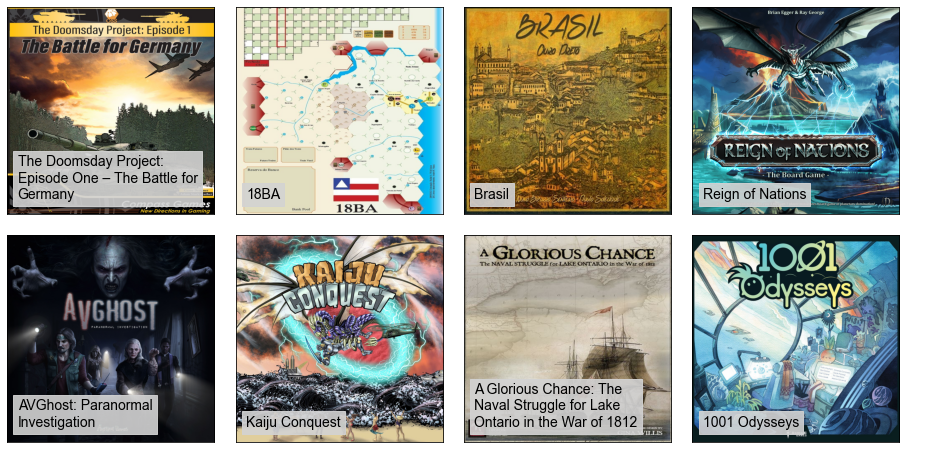

In [113]:
# Illustrate 8 of these games
future_yr_id = future_yr['bgg_id'].values[:8]
future_yr_imgs = [ref_dicts['images'][i] for i in future_yr_id]
subplot_images(future_yr_imgs, future_yr['name'].values[:8])

When we view these games on the BGG website, these games all do not have a rating yet, and most are missing information on the game types, categories, etc. Furthermore, there is always a chance that the publications may be delayed or not go through if it is crowd-funded on kickstarter and did not meet its pledge goals. Hence, we will not be keeping these games in our analysis. Since it is still January 2021, it is safe to remove all games from 2021 onwards.

In [26]:
# Remove these games
df = df.loc[df['year']<2021]

In [27]:
# See games with high count for min_players
df['min_players'].value_counts().sort_index()

1.0     10181
2.0     46906
3.0      6385
4.0      1729
5.0       189
6.0       173
7.0        49
8.0       125
9.0        15
10.0       26
11.0        2
12.0       14
13.0        4
14.0        1
15.0        4
16.0        3
20.0        1
40.0        1
50.0        1
Name: min_players, dtype: int64

In [28]:
# View 20 games with high player counts
df.loc[df['min_players']>=8].sample(20, random_state=42)

bgg_id  \
64740  169702   
40237   63539   
4171     4823   
25180   28935   
73401  206857   
86630  274017   
23560   27087   
20110   23139   
4177     4829   
84489  263191   
84530  263347   
4170     4822   
76335  224488   
20324   23369   
44293   84976   
40726   64962   
67359  178734   
4153     4804   
24999   28719   
87957  280772   

                                                                            name  \
64740                                                           Airship Assassin   
40237                                                            Lupus in Tabula   
4171                               Mysteries by Vincent: Lynched in Lucre Valley   
25180                                            An Evening of Murder: Last Call   
73401                                         Are You the Cultist? Party Edition   
86630                                                                    Projeto   
23560                  Defining a Nation: India on the Eve of Independence, 1945   
20110                                                        Death on the Gambia   
4177   The Daisy Diamond Detective Series: Episode #2 – The Time Machine Mystery   
84489                                   Murder Mystery Party: Murder in the Pits   
84530                                        Miss Tree and the Stolen Broomstick   
4170                                   Mysteries by Vincent: Hard Drive Homicide   
76335                                            Malachai Stout's Family Reunion   
20324                                                                DEMOCRACity   
44293                                   Das Kopflose Dinner: Die Verlobungsfeier   
40726                                             Invasion of the Body Snatchers   
67359                                                      Rocky Mountain Murder   
4153                                 Mysteries by Vincent: Rocky Mountain Mayhem   
24999                                      Murder Mystery Party: Murder by Magic   
87957          Deadly Disclosures: Murder in Chocville – A Murder Mystery Dinner   

         year game_type   designer          artist  \
64740  2014.0       NaN        NaN             NaN   
40237  2001.0      5498       3402  3400,3402,2211   
4171   1997.0       NaN       1867             NaN   
25180  2006.0       NaN          3               3   
73401  2016.0       NaN      14991     14697,21119   
86630  2019.0       NaN      60637             NaN   
23560  2005.0       NaN  8073,8087             NaN   
20110  2001.0       NaN       9601             NaN   
4177   2001.0       NaN       1867             NaN   
84489  2003.0       NaN        NaN             NaN   
84530  2003.0       NaN        NaN             NaN   
4170   1998.0       NaN       1867             NaN   
76335  2010.0       NaN      85263             NaN   
20324  2005.0       NaN       7044             NaN   
44293  2010.0       NaN      41497           41498   
40726  2009.0       NaN      27360             NaN   
67359  2010.0       NaN      82832             NaN   
4153   1997.0       NaN       1867             NaN   
24999  2000.0       NaN          3               3   
87957  2019.0       NaN       7352          118183   

                                  publisher  min_players  max_players  \
64740                                 27178          8.0         60.0   
40237  917,4304,2973,1391,8923,8291,10,9234          8.0         24.0   
4171                                   1119          8.0          8.0   
25180                                  2365          8.0          8.0   
73401                                 12824          8.0         24.0   
86630                                     4         10.0         40.0   
23560                                  6330         13.0         25.0   
20110                                  5369          8.0         10.0   
4177                                   1119          8.0          8.0   
84489              

All these games are very niche and not popular at all (the number of votes are very low). They are also missing alot of information. However, some party games may be within this list they normally require a higher player count. In spite of that, it is still very difficult to amass at least 8 players each time you want to play a board game. Since these games will not satisfy the general crowd which we will be recommending games to, they will be dropped from the dataframe.

In [29]:
# Dropping games
df = df.loc[df['min_players']<8]

In [30]:
# Look at min_age values
df['min_age'].value_counts().sort_index()

1.0         12
2.0        165
3.0       1258
4.0       1949
5.0       2690
6.0       4125
7.0       3048
8.0      12506
9.0       1055
10.0      9113
11.0       289
12.0     10841
13.0      2569
14.0      3567
15.0       531
16.0       695
17.0       270
18.0       777
19.0         3
20.0        13
21.0       110
25.0         1
30.0         7
36.0         2
40.0         1
45.0         2
50.0         2
60.0         2
90.0         2
112.0        1
Name: min_age, dtype: int64

In [31]:
# View 40 games with min_age above 18
df.loc[df['min_age']>=18].sample(40, random_state=42)

bgg_id                                           name    year  \
54825  131812                                       [_BLÄNK]  2012.0   
93986  307156                              Micos y Bananazos  2019.0   
7196     8209                   Serata in Giallo: Sangue Blu  1996.0   
91782  297945                       Who is the Biggest Slut?  2010.0   
51129  119440                                 Phantasmagoria  2011.0   
12727   14525                                Outburst Remix!  2004.0   
40517   64298                               A Trip to Mexico  1996.0   
37637   48957                   Queen's Blade: The Colosseum  2008.0   
75028  217155                 Les Recettes Pompettes: Le Jeu  2016.0   
95548  313947                                   Animalesque!  2020.0   
13441   15310                   HotFlash! The Menopause Game  2003.0   
73077  205158                     Codenames: Deep Undercover  2016.0   
58915  147149                     A Game For Good Christians  2013.0   
66535  175893                                 Bedroom Battle  2015.0   
40339   63809  South Park: The Totally Sweet DVD Trivia Game  2009.0   
43172   73280                     American Throttle the Game  2003.0   
64298  168012                       Pot Farm: The Board Game  2015.0   
9012    10303                                     F*ck This!  2003.0   
78680  235482                Utter Nonsense: Naughty Edition  2017.0   
32200   37000                                        Partini  2008.0   
97796  323385                                    Hoy se sale  2020.0   
52944  126216                              Big Bag of Schwag  2004.0   
93287  303881                                 Doin' The Most  2019.0   
57656  142682                     Rob Delaney's War of Words  2013.0   
57308  141255                                    Loversopoly  2012.0   
45160   89364                        HouseBoy the Board Game  2011.0   
59332  148523                           Beard! The Card Game  2013.0   
74455  213052     PM GALAXY: A Project Management Board Game  2017.0   
93409  304419                              Moonlight Brewers  2020.0   
94566  309709                   Karty Dżentelmenów: Epizod 3  2017.0   
78965  236872                                 The Naked Game  2017.0   
54545  130900                            Lakebilly Card Game  2013.0   
21012   24170                               SexPlay the Game  1997.0   
73973  209671                  Zona: The Secret of Chernobyl  2019.0   
80350  244152                                Suddenly Stoned  2018.0   
65963  174031  Party Time: The Game That's as Fun as You Are  2015.0   
24780   28467                                     Match Mate  2007.0   
47687  102329                                         Huikka  2011.0   
93267  303774   Trivial Pursuit: Rock & Pop Edition (Travel)  1995.0   
25101   28840                                           Orgy  2002.0   

      game_type                     designer         artist  \
54825       NaN                          NaN            NaN   
93986       NaN                          NaN            NaN   
7196        NaN                    2816,2817            NaN   
91782       NaN                          NaN            NaN   
51129       NaN                          NaN            NaN   
12727       NaN                         3233            NaN   
40517       NaN            33828,33829,33830            NaN   
37637       NaN                            3          36814   
75028       NaN                          NaN            NaN   
95548       NaN                        54032          54032   
13441       NaN                         4704            NaN   
73077      5498                          789    12402,28450   
58915       NaN                          NaN            NaN   
66535       NaN                100925,100926            NaN   
40339       NaN                            3            NaN   
43172       NaN                  38260,38261  

On average, the popular board games are known to have a lower minimum age requirement to cater to a wider audience. Filtering the board games with minimum age above 18, we could clearly see that most of these games falls within two broad categories:
* Games that contain either profanity or adult/sexual content
* Drinking games

These are not the genre of board games which we will be recommending, so we will be removing these games. The minimum age cut-off point was chosen to be 18 since it is the highest age of consent in countries.

In [32]:
# View games with min_age above 18 and still popular
pop_abv_18 = df.loc[(df['min_age']>=18) & (df['num_votes']>1000)]
pop_abv_18

bgg_id                              name    year  game_type  \
65432  172242      Exploding Kittens: NSFW Deck  2015.0       5498   
67589  179719             Risk: Game of Thrones  2015.0  4664,5496   
69837  188920  This War of Mine: The Board Game  2017.0       5496   
70859  193621                     Joking Hazard  2016.0       5498   
73077  205158        Codenames: Deep Undercover  2016.0       5498   

               designer             artist  \
65432  71478,80158,5874              71478   
67589             49208                NaN   
69837        5143,87430  93734,5143,114320   
70859                 3                NaN   
73077               789        12402,28450   

                                                          publisher  \
65432                                   4,3320,23043,157,18852,7466   
67589                                    634,15619,9466,26208,32781   
69837  29412,16688,4304,17917,157,34522,2973,4617,15605,27654,37459   
70859                                                         29082   
73077               157,10768,7345,29194,264,36876,25203,30552,7466   

       min_players  max_players  min_players_rec  max_players_rec  \
65432          2.0          5.0              3.0              5.0   
67589          2.0          7.0              3.0              7.0   
69837          1.0          6.0              1.0              3.0   
70859          3.0         10.0              3.0              7.0   
73077          4.0          8.0              4.0              8.0   

       min_players_best  max_players_best  min_age  min_age_rec  min_time  \
65432               4.0               5.0     18.0    14.312500      10.0   
67589               4.0               5.0     18.0          NaN     120.0   
69837               1.0               1.0     18.0    15.942857      45.0   
70859               5.0               5.0     18.0          NaN      30.0   
73077               6.0               6.0     18.0          NaN      15.0   

       max_time                       category  \
65432      20.0       1089,1002,1116,1079,1118   
67589     240.0                 1064,1086,1019   
69837     120.0       1022,1020,1118,1069,1101   
70859      90.0       1002,1116,1079,1118,1030   
73077      15.0  1002,1039,1118,1030,1081,1025   

                                                     mechanic  cooperative  \
65432                                2040,2685,2661,2004,2686            0   
67589                                     2080,2046,2072,2685            0   
69837  2001,2023,2072,2676,2661,2028,2070,2819,2027,2015,2082            1   
70859                                          2040,2865,2020            0   
73077                                     2893,2047,2661,2019            0   

                      family implementation  \
65432        7334,8374,62860            NaN   
67589       22783,5068,56924            181   
69837  8374,62202,5666,65494            NaN   
70859                   8374            NaN   
73077      37062,62860,62861            NaN   

                              integration    rank  num_votes  avg_rating  \
65432                              172225  2628.0     7474.0     6.22528   
67589                                 NaN  2821.0     1264.0     6.76382   
69837                                 NaN   150.0     8135.0     7.83998   
70859                                 NaN  1994.0     4243.0     6.42785   
73077  178900,220775,220774,198773,290028  1708.0     2658.0     6.62286   

       stddev_rating  bayes_rating  complexity  language_dependency  
65432        1.78060       5.95770      1.0760                  NaN  
67589        1.55898       5.91451      2.8125                  NaN  
69837        1.55453       7.36472      3.2525             4.882353  
70859        1.66720       6.10391      1.0377                  NaN  
73077        1.59106       6.19380      1.3333                  NaN

Although we have decided to remove the games with minimum age requirement above 18, we still need to check if any of the popular board games will be removed unintentionally. Games such as "Exploding Kittens: NSFW Deck" and "Joking Hazard" are examples of games which were popularized due to the humour that comes along with its profanity. We will still recommend these games.

In [33]:
# Drop games with min_age 18 and above
df = df.loc[df['min_age']<18]
df = pd.concat([df, pop_abv_18], ignore_index=True)

In [34]:
# See min_time values
df['min_time'].value_counts().sort_index()

1.0           201
2.0           185
3.0            86
4.0            24
5.0          1822
6.0            19
7.0            20
8.0            31
9.0             2
10.0         4793
11.0            2
12.0           27
13.0            6
14.0            2
15.0         6752
16.0            8
17.0            5
20.0         7086
23.0            2
24.0            3
25.0          732
27.0            1
30.0        10781
33.0            1
35.0          157
36.0            1
37.0            2
38.0            1
39.0            1
40.0          823
41.0            1
42.0            2
45.0         4304
46.0            3
50.0          144
55.0            8
60.0         5530
65.0            1
66.0            1
68.0            1
70.0           29
75.0          160
80.0          101
85.0            2
90.0         2183
95.0            1
99.0            4
100.0         180
105.0           2
110.0           4
111.0           1
115.0           2
120.0        1983
135.0           2
140.0           4
150.0     

In [35]:
# View 40 games
df.loc[df['min_time']>240].sample(40, random_state=42)

bgg_id  \
5003    15990   
16700   85424   
51164  304492   
2800     9132   
2290     7588   
46012  273966   
28439  163097   
8469    25516   
1607     4759   
1982     6495   
12229   41066   
54394  325555   
17365   91080   
1356     3870   
48822  291434   
15967   73712   
3380    11050   
8837    26426   
20177  116046   
2306     7622   
2560     8397   
44832  265802   
42747  254125   
21001  122248   
18376  101077   
2784     9093   
493      1145   
3206    10581   
25127  145321   
2330     7750   
5997    18908   
2331     7752   
2004     6559   
7650    23407   
50586  301204   
25126  145320   
2324     7739   
10450   30400   
1456     4204   
51457  306728   

                                                                                             name  \
5003                                                                       Storm Over Scandinavia   
16700                                                   La Bataille de la Moscowa (Third Edition)   
51164  In Deo Veritas: Fast Play Rules for Exciting Seventeenth Century Battles in Smaller Scales   
2800                                                                      18C2C: Manifest Destiny   
2290                                   Principles of War: Napoleonic – Wars Between 1792 and 1815   
46012                            SEMPER FIDELIS: Reglamento multitemporal de batallas con figuras   
28439                                         Beyond the Rhine: The Campaign for Northwest Europe   
8469                                                   A Fatal Attraction: The Gallipoli Campaign   
1607                                                     The War to End All Wars: Box Set Edition   
1982                                                           Iron Tide: Panzers in the Ardennes   
12229                                                                                Virgin Queen   
54394                                                    Cantaloop: Book 1 – Breaking into Prison   
17365                                                                                Andean Abyss   
1356                                                                                       7 Ages   
48822                                                                  Axis Empires Final Edition   
15967                                                                                Mystic Realm   
3380                                                            Bastogne or Bust (Second Edition)   
8837                                                                               Mind Scrambler   
20177                                                                                        18NY   
2306                                                                               Morsecode ···–   
2560                                                                          Rommel at the Meuse   
44832                                                                                     Crypt X   
42747                                                                             The Tale of Ord   
21001                                                         Star Requiem: Humanity's Last Stand   
18376                                                                     Storm over Pearl Harbor   
2784                                                                1777: The Year of the Hangman   
493                                                                                 City of Chaos   
3206                                                       Summer Storm: The Battle of Gettysburg   
25127                                                                           Conjunction Point   
2330                             Tannenberg: Eagles in the East / Galicia: The Forgotten Cauldron   
5997                                                  Cactus Throne: The Mexican War of 1862-1867   
2331                                                                         

In general, board games should not extend over the 2-3 hours mark. Despite saying that, there are people who like warfare-style board games such as "Risk", a niche category of games which tend to play over much a much longer time compared to other categories. We also observe that the board games with minimum time above 240 mins are mostly warfare-style games. In order to account for the people who enjoy this genre of games, we will not remove the board games if they are popular. 

In [36]:
pop_time_240 = df.loc[(df['min_time'].between(240,480)) & (df['num_votes']>1000)]
pop_time_240 

bgg_id                                                    name    year  \
42         91                                          Paths of Glory  1999.0   
189       423             1856: Railroading in Upper Canada from 1856  1995.0   
369       833                                          For the People  1998.0   
391       875                                           Roads & Boats  1999.0   
546      1262                                  Axis & Allies: Pacific  2001.0   
715      1829                                          Risk 2210 A.D.  2001.0   
1177     3353                      World War II: Barbarossa to Berlin  2002.0   
1356     3870                                                  7 Ages  2004.0   
2257     7480                                           Sword of Rome  2004.0   
3060    10093                                           Axis & Allies  2004.0   
3638    11825                                       Empire of the Sun  2005.0   
5491    17405                          1846: The Race for the Midwest  2005.0   
6265    19622             A Victory Lost: Crisis in Ukraine 1942-1943  2006.0   
7475    22877                                          Fields of Fire  2008.0   
8847    26457                              Successors (Third Edition)  2008.0   
10152   29603                                    D-Day at Omaha Beach  2009.0   
11244   35052                       Axis & Allies Anniversary Edition  2008.0   
12229   41066                                            Virgin Queen  2012.0   
12469   41863                                     Axis & Allies: 1942  2009.0   
13615   55829                              Axis & Allies Pacific 1940  2009.0   
14223   61692                               Axis & Allies Europe 1940  2010.0   
15271   68264                           No Retreat! The Russian Front  2011.0   
17365   91080                                            Andean Abyss  2012.0   
22659  130960  Triumph & Tragedy: European Balance of Power 1936-1945  2015.0   
39568  233078                       Twilight Imperium: Fourth Edition  2017.0   

       game_type       designer                               artist  \
42          4664            484                    2652,23441,71,140   
189         5497            198                    27910,21797,23115   
369         4664            152                         71,11872,140   
391         5497        270,407                             408,7246   
546         4664   1743,442,575                                32880   
715         4664        442,262                                  NaN   
1177        4664            484                               71,140   
1356        5497            296              22659,22807,22805,22806   
2257        4664           2615                               71,140   
3060        4664        575,604              13324,13560,16822,18317   
3638        4664            152                         20307,71,140   
5491        5497            150               497,71,11872,140,97845   
6265        4664           4350                                11857   
7475        4664           1397                             24469,71   
8847        4664   135,6750,140       43152,71,11872,20649,140,18461   
10152       4664            679                                 1893   
11244       4664            575  28510,71090,19124,13560,21974,28511   
12229  4664,5497            674                        2652,71,11856   
12469       4664            575                                19124   
13615       4664            575                                28510   
14223       4664            575                                28510   
15271       4664          11119                               71,140   
17365       4664            772              49323,2652,71,34490,140   
22659       4664             62                              2652,71   
39568  5496,5497  96049,6651,21                                11988   

                           

In [37]:
# Drop games with min_time above 240
df = df.loc[df['min_time']<240]
df = pd.concat([df, pop_time_240], ignore_index=True)

In [38]:
# Df shape after first-cut cleaning
df.shape

(49139, 30)

### Missing Values

We want to look at the missing values.

In [39]:
# See the columns with null values
pd.set_option('display.max_rows', None)
mv = df.isnull().sum().sort_values(ascending=False)
# Filter out missing values
mv = mv[mv.values > 0]
mv_percent = mv / df.shape[0] * 100
pd.concat([mv, mv_percent], axis=1, keys=['Total', 'Percentage'])

Total  Percentage
language_dependency  48455   98.608030
min_age_rec          48371   98.437087
integration          46853   95.347891
implementation       45930   93.469546
game_type            38992   79.350414
rank                 34600   70.412503
bayes_rating         34372   69.948513
complexity           23169   47.149922
artist               21253   43.250778
family               19052   38.771648
avg_rating            8916   18.144447
mechanic              5624   11.445084
designer              5456   11.103197
category               892    1.815259
max_players_best       756    1.538493
max_players_rec        756    1.538493
max_players            756    1.538493
publisher                6    0.012210
stddev_rating            1    0.002035
num_votes                1    0.002035

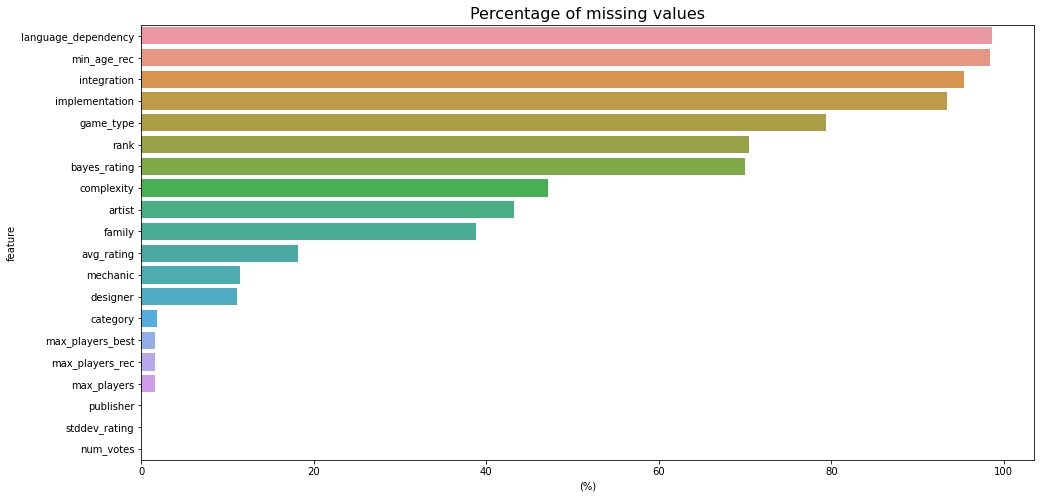

In [40]:
# Plot the missing values using a bar plot
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.barplot(mv_percent.values,mv_percent.index)
ax.set_xlabel('(%)')
ax.set_ylabel('feature')
ax.set_title('Percentage of missing values', fontsize=16);

We observed that there is a high percentage of null values (>50% missing) for a number of features. We will leave most of them for now and decide how to deal with the missing values as we continue with further EDA on the features. However, there are some features that we will not be analysing. We will remove these features first.

In [41]:
# Remove unimportant features
df.drop(columns=['integration', 'implementation', 'family'], inplace=True)

## Further EDA  

Exploratory data analysis to further understand our data through summaries and visualizations.

In [42]:
# Data Types
df.dtypes

bgg_id                   int64
name                    object
year                   float64
game_type               object
designer                object
artist                  object
publisher               object
min_players            float64
max_players            float64
min_players_rec        float64
max_players_rec        float64
min_players_best       float64
max_players_best       float64
min_age                float64
min_age_rec            float64
min_time               float64
max_time               float64
category                object
mechanic                object
cooperative              int64
rank                   float64
num_votes              float64
avg_rating             float64
stddev_rating          float64
bayes_rating           float64
complexity             float64
language_dependency    float64
dtype: object

### Games Released Over Time  

We want to find out the number of board games released over time.

In [43]:
df['year'] = df['year'].astype(int)

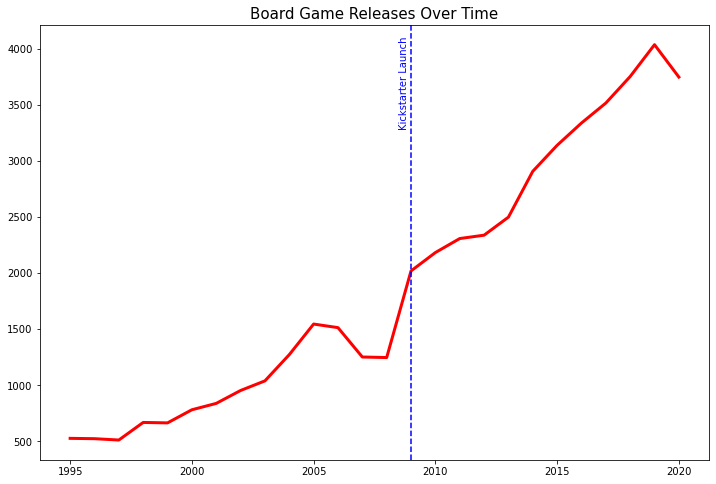

In [44]:
yr_plot = df['year'].value_counts().sort_index()

plt.figure(figsize=(12,8))
plt.plot(yr_plot.index, yr_plot.values, linewidth=3, c='r')
plt.title('Board Game Releases Over Time', fontsize=15)
plt.axvline(2009, ls='--', c='b')
plt.text(2008.5, 3300, 'Kickstarter Launch', rotation='vertical', c='b');

As expected, we could clearly see an upward trend in the publications of board games throughout the years, with a slight dip during the period of years 2007-2008. The dip in publications is likely caused by the [global financial crisis](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008) during that period where economies worldwide were all struggling. The publications of board games skyrocketed ever since [Kickstarter](https://www.kickstarter.com/), a crowdfunding company, was launched in 2009. Kickstarter has been revolutionary to the board game market, as it gives avid gamers a chance to put their ideas out for other like-minded people. In 2015 alone, "Conan" the board game launched a Kickstarter campaign which received full funding of \\$80,000 within 5 mins from launch. By the end of the campaign, it raised a astounding amount of \\$3 million thanks to 15,000 backers. [[source](https://medium.com/@peterattia/the-full-history-of-board-games-5e622811ce89)][[source](https://www.crowdfundinsider.com/2015/02/62567-conan-captures-over-3-million-during-final-hours-of-campaign-becomes-most-successful-board-game-in-kickstarter-history/)].

### Ratings

Ratings for the board games are always important since the higher the rating, the better the board game should be in the opinions of the public. This also means that highly rated games should be prioritized when recommending to the people as they would be more likely to like the recommended game.

#### Average ratings

We want to further understand the difference between average ratings and bayesian average ratings. Based on the bar plot above, there are significantly more missing values in "bayes_rating" as compared to that of "avg_rating". [Bayesian average ratings](https://boardgamegeek.com/thread/71129/what-bayesian-average) are an excellent way tackle various problems with a rating system:  
* Not everyone plays every game or even a small percentage of the games available.
* People self-select the board games thay want to rate. A small but devoted group of people may rack up a high average rating for a board game, but the game would never get popular enough for many people to try it.
* Inconsistency in the ratings of different people (e.g. some give many 10's, other almost never).
* People who rate the games may not be the intended audience of the game in the first place. So the rating is biased.

It is not possible to figure the function used by BGG to calculate the bayesian average ratings but some leads in the BGG forum reported that there is a minimum of 30 "num_votes" to be made for a "bayes_rating" to be calculated for a board game. Also, only board games with a bayesian average rating calculated would have a rank. We could see "bayes_rating" as a good indicator of board games which have at least seen a substantial amount of plays and rates before we can recommend them to others.

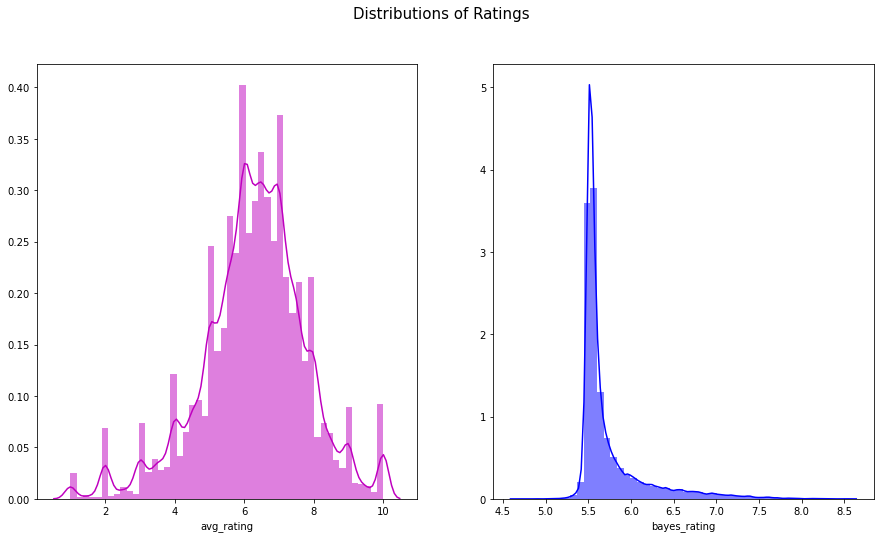

In [45]:
# Plot distributions of bayes_rating and avg_rating
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(df['avg_rating'], ax=ax[0], color='m', label='avg_rating', hist_kws={'alpha':0.5})
sns.distplot(df['bayes_rating'], ax=ax[1], color='b', label='bayes_rating', hist_kws={'alpha':0.5})
plt.suptitle('Distributions of Ratings', fontsize=15);

We see that the distribution of "bayes_rating" is heavily skewed to the right (positive) which may not be ideal if we are going to develop a machine learning model using "bayes_rating" as a feature of target. We also noticed multiple modes in the distribution of "avg_rating", mostly spiking at the rounded values (i.e. 2.0, 3.0, 4.0, 5.0, etc.). It could be because of the board games with very little number of ratings, for example if only a few people rated a game to be 5.0, the average will be 5.0 exactly.

In [46]:
# Verify that board games without a rank do not have bayes_rating
df.loc[(df['rank']>0) & (df['bayes_rating'].isnull())]

Empty DataFrame
Columns: [bgg_id, name, year, game_type, designer, artist, publisher, min_players, max_players, min_players_rec, max_players_rec, min_players_best, max_players_best, min_age, min_age_rec, min_time, max_time, category, mechanic, cooperative, rank, num_votes, avg_rating, stddev_rating, bayes_rating, complexity, language_dependency]
Index: []

In [47]:
# Verify that board games with less than 30 num_votes,
# do not have bayes_rating
df.loc[(df['num_votes']>30) & (df['bayes_rating'].isnull())]

Empty DataFrame
Columns: [bgg_id, name, year, game_type, designer, artist, publisher, min_players, max_players, min_players_rec, max_players_rec, min_players_best, max_players_best, min_age, min_age_rec, min_time, max_time, category, mechanic, cooperative, rank, num_votes, avg_rating, stddev_rating, bayes_rating, complexity, language_dependency]
Index: []

We verified that it is indeed true that board games without a bayesian rating do not have a rank nor at least 30 numbers of rates/votes. These are the board games which we do not want to recommend since they are not as well-received at the time being. As such, we want to drop all the games without a rank or bayesian rating.

In [48]:
# Dropping board games without rank or bayes_rating
df = df.loc[df['rank']>0]
df.shape

(14539, 27)

In [49]:
# Check if anymore null values in bayes_rating
df.isnull().sum()

bgg_id                     0
name                       0
year                       0
game_type               7958
designer                 336
artist                  3188
publisher                  0
min_players                0
max_players               55
min_players_rec            0
max_players_rec           55
min_players_best           0
max_players_best          55
min_age                    0
min_age_rec            13776
min_time                   0
max_time                   0
category                 212
mechanic                1061
cooperative                0
rank                       0
num_votes                  0
avg_rating                 0
stddev_rating              0
bayes_rating               0
complexity               319
language_dependency    13858
dtype: int64

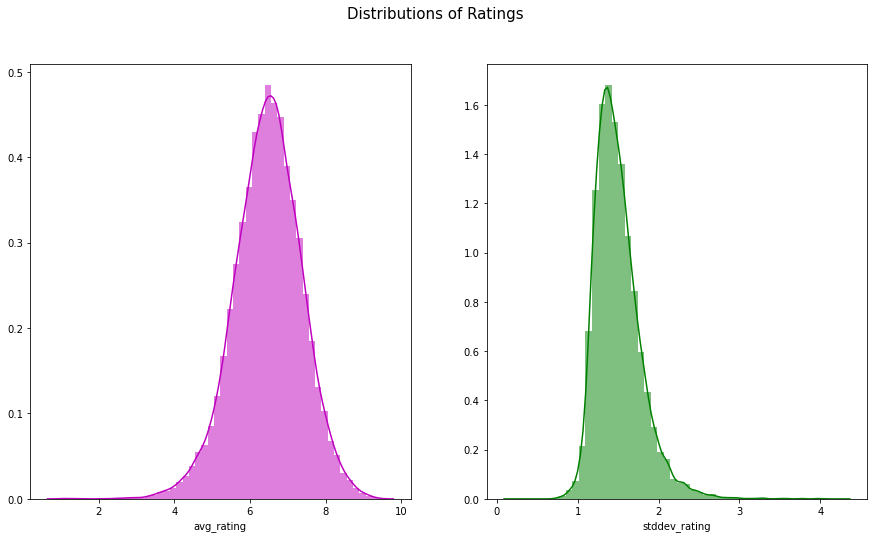

In [50]:
# Re-Plot distributions of avg_rating and stddev_rating
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(df['avg_rating'], ax=ax[0], color='m', label='avg_rating', hist_kws={'alpha':0.5})
sns.distplot(df['stddev_rating'], ax=ax[1], color='g', label='bayes_rating', hist_kws={'alpha':0.5})
plt.suptitle('Distributions of Ratings', fontsize=15);

We immediately noticed that the distribution of the average rating became very close to a normal distribution with a slight left skew. The mean of the average ratings is around 6.5. Plotting the distribution of "stddev_rating", we also see a single modal histogram with a mean of about 1.5.

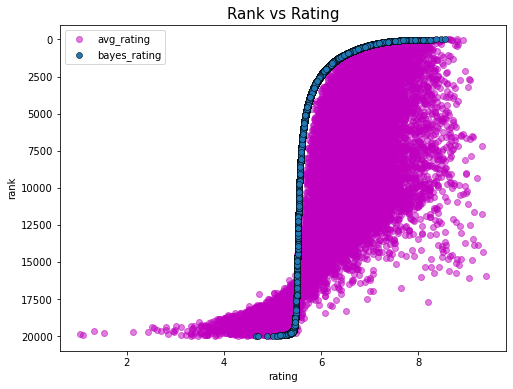

In [51]:
# Plot relationship between rank and bayes_rating
plt.figure(figsize=(8,6))
ax = plt.gca()

ax.scatter(df['avg_rating'], df['rank'], color='m', alpha=0.5, label='avg_rating')
ax.scatter(df['bayes_rating'], df['rank'], edgecolor='k', linewidths=0.5, label='bayes_rating')
ax.invert_yaxis()
plt.xlabel('rating')
plt.ylabel('rank')
plt.legend()
plt.title('Rank vs Rating', fontsize=15);

We could clearly see that the ranking of the board games are correlated to the bayesian rating and average rating. We also noticed the high concentration of board games with a bayesian rating of about 5.5.

### Overview of Numerical Variables

Pick out the numerical variables for analysis. We first want to see if they are correlated to each other in any way.

In [52]:
# List of numerical variables
num_df = df.select_dtypes(include='float64')
num_df.columns

Index(['min_players', 'max_players', 'min_players_rec', 'max_players_rec',
       'min_players_best', 'max_players_best', 'min_age', 'min_age_rec',
       'min_time', 'max_time', 'rank', 'num_votes', 'avg_rating',
       'stddev_rating', 'bayes_rating', 'complexity', 'language_dependency'],
      dtype='object')

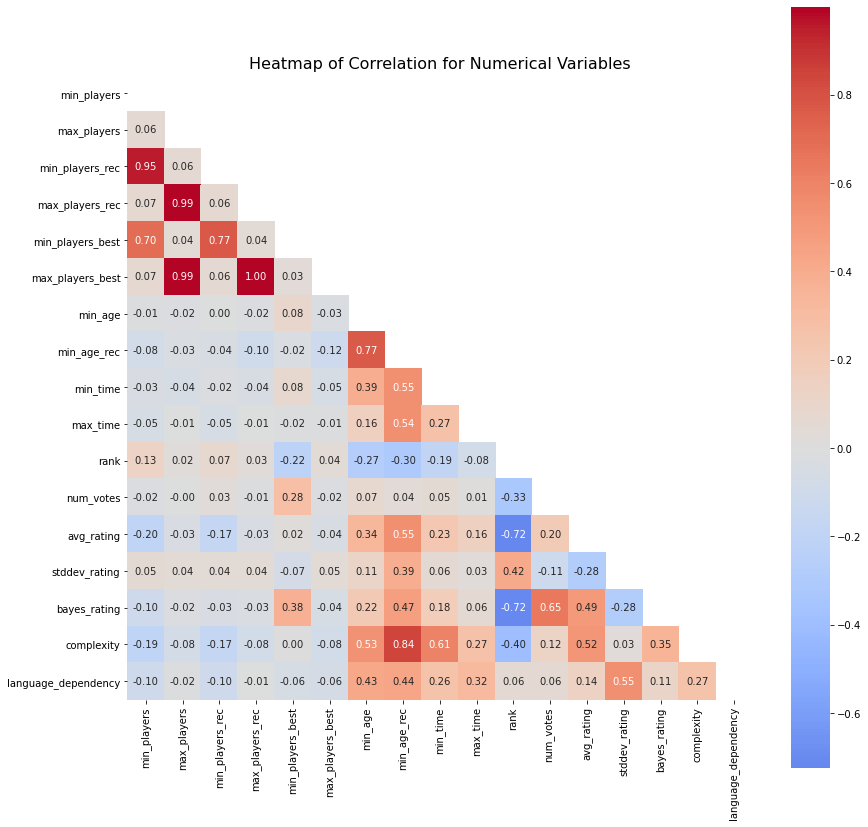

In [53]:
# Plotting a heatmap to see the correlation between the variables
corrmat = num_df.corr()
mask_matrix = np.triu(corrmat)

plt.figure(figsize=(14,14))
plt.title('Heatmap of Correlation for Numerical Variables', fontsize=16)
sns.heatmap(corrmat, cmap='coolwarm', mask=mask_matrix, square=True, annot=True, fmt='.2f', center=0);

Based on the heatmap above, we are able to able to pick out several insights on the data we collected.   

Observations:  
1. There are quite a number of highly positive correlation variables (r>0.85) and they comprise of the features for minimum/maximum players of the board games. For example, "max_players_rec" has a correlation of 1.0 with "max_players", meaning that these two columns have the exact same values. It suggests that for the minimum and maximum player count of each board game, there is little to no difference between the number listed by the game design and the number recommended by the people of the BGG community or the number rated best by the BGG community. As such, we would only use one variant for minimum and maximum player counts, which we decided to be the count given by game design.

2. Similar to point 1, we see a high positive correlation (r>0.75) between "min_age" and "min_age_rec". We would again choose to use only one variant in our recommender system and we decided to go with the minimum age as stated by game design. Furthermore, we found earlier that more than 98% of the data for "min_age_rec" are missing, affirming our choice of keeping "min_age". We also would not pay too much attention to the correlations for "min_age_rec" since the data is mostly missing.

3. The minimum time needed seems to have some positive correlation with the minimum age required and complexity. Logically, the longer the minimum time is needed to play the board game, the higher the complexity. Games with higher complexity should also equate to higher minimum age requirement. That may also be why we see that complexity has some positive correlation (r~0.5) with the minimum age requirement.

4. The ratings have a very high negative correlation (r<-0.70) with the rankings of the board game. This is expected, since higher rankings are represented by a lower numerical value. So the higher the ratings, the lower the ranking value (higher the rank on the charts). We did notice that the "rank" feature has a slightly higher percentage of missing data as compared to "bayes_rating". Since the rating would likely explain the same information as the rankings, we will choose to keep only the ratings for our analysis.

5. As we would expect, there is a high positive correlation between "bayes_rating" and "num_votes", "avg_rating". This is because the bayesian average rating was highly likely derived from both "avg_rating" and "num_votes. There is also some correlation between "bayes_rating" and "stddev_rating".

6. The standard deviations of ratings are positively correlated (r~0.42) to the rankings of the board games. This means that as "stddev_rating" increases, the "rank" of the board increases. The standard deviation could also be seen as the spread of the ratings and a larger spread would equate to higher number of mixed ratings amongst those who rated the board game (i.e. some people rated highly for that game but some rated poorly).

7. Complexity is also positively correlated to minimum and maximum time required to play the board game. It is perfectly understandable since the more complex the game is, the longer it would take to play. Complexity is also negatively correlated (r~-0.40) to "rank", which suggests that higher ranking board games have a tendency to be more complex. This is interesting because the general public would normally have a strong liking towards board games which are less complex, which is not the case here. We could attribute this to the fact that the ratings on BGG website were given by board gamers and not the 'general public'. However, we still need to keep this in mind when we move forth to the recommending of games and have to consider the target audience.

Although it may seem like "language_dependency" has some correlation with some of the features, it has a very large percentage (>98%) of missing data. It is not usuable for our analysis or building of recommender systems since it would not explain most of the information anyway. 

In [54]:
# Variables to drop
var_to_drop = ['min_players_rec', 'max_players_rec', 'min_players_best', 'max_players_best', 'min_age_rec', 'language_dependency']
df.drop(columns=var_to_drop, inplace=True)

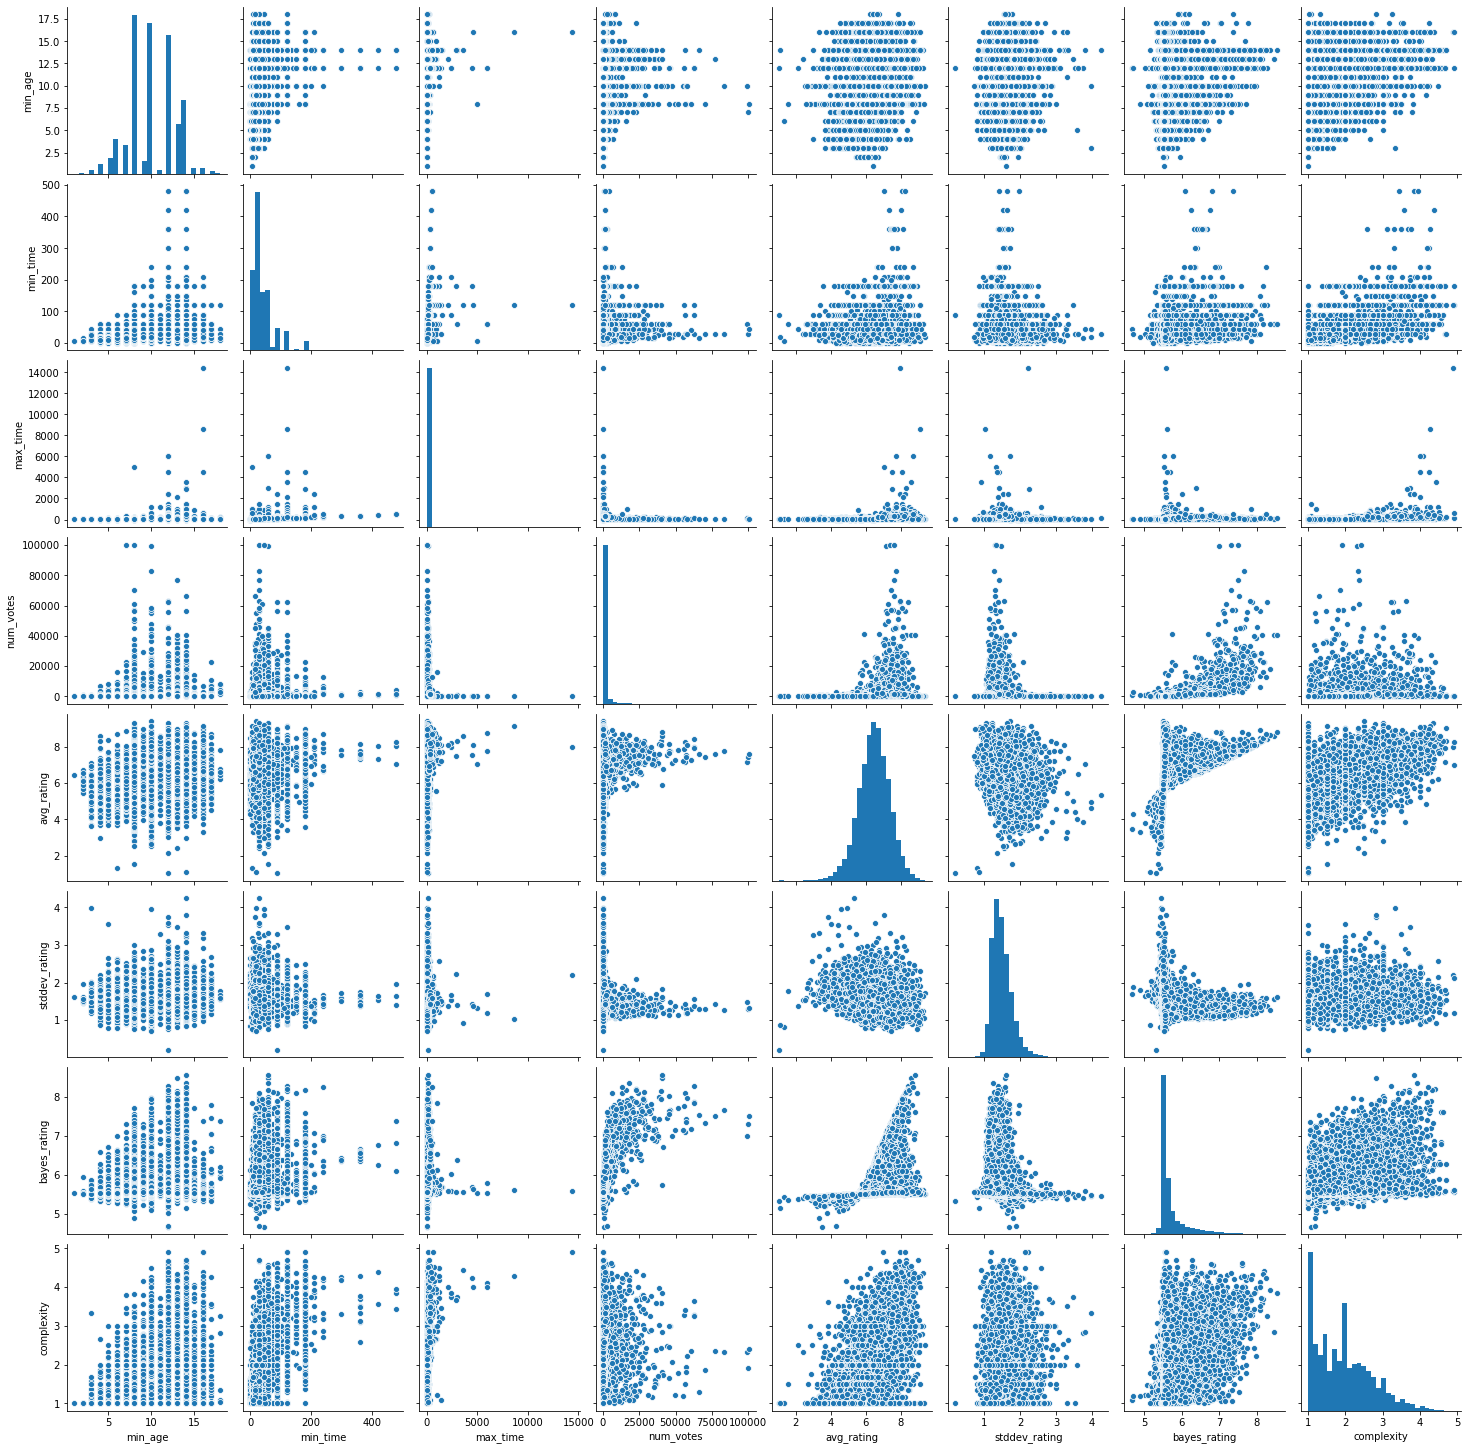

In [55]:
# Pairplot of variables with some correlation
sns.pairplot(df[['min_age', 'min_time', 'max_time', 'num_votes', 'avg_rating', 'stddev_rating', 'bayes_rating', 'complexity']], diag_kws = {'bins':30});

From the pairplot above, we could observe the general trends between any two variables and also have an overview of the distributions for all the variables. We can see that the distribution of "num_votes" is heavily right-skewed, indicating that there is a smaller number of board games which have significantly more votes/rates as compared to the other board games. This means that the popular board games are really much more popular than the other games and are well-distinguished from the rest.

We also noted from the distribution of "complexity" that there are considerably a higher proportion of board games with a low complexity of about 1.0, and a spike at value 2.0 as well. From the scatter plots we could see some positive correlation between complexity and "min_time", "min_age", "avg_rating".

We see that there is an obvious anomaly in the "max_time" feature as well.

In [56]:
# Investigate anomaly
df['max_time'].describe()

count    14539.000000
mean        63.085013
std        190.329527
min          1.000000
25%         30.000000
50%         45.000000
75%         60.000000
max      14400.000000
Name: max_time, dtype: float64

In [57]:
# Check out the board games
df[df['max_time']>8000]

bgg_id                             name  year game_type       designer  \
24242  158793  Atlantic Wall: D-Day to Falaise  2014      4664           1893   
35931  236650          1985: Under an Iron Sky  2018      4664  108526,103986   

              artist publisher  min_players  max_players  min_age  min_time  \
24242           1893       102          2.0          6.0     16.0     120.0   
35931  103990,103986     37916          2.0          6.0     16.0     120.0   

       max_time   category             mechanic  cooperative    rank  \
24242   14400.0  1019,1049            2026,2974            0  8082.0   
35931    8640.0  1069,1019  2072,2026,2070,2974            0  6611.0   

       num_votes  avg_rating  stddev_rating  bayes_rating  complexity  
24242       67.0     7.96493        2.20596       5.57702      4.8889  
35931       84.0     9.11786        1.03592       5.61211      4.2727

Since the games are not very popular in the first place, we decide to drop them.

In [58]:
# Dropping anomaly
df = df[df['max_time']<8000]

### Ranking of Board Games

Through EDA so far, we have found that the ranking of the board games are very telling of the characteristics which people like. It is quite a reliable means of judging a board game. To trim the dataset further, we decide to keep the first 10,000 ranked board games for further analysis.

In [59]:
df['rank'].describe()

count    14537.000000
mean      9284.754695
std       5799.086541
min          1.000000
25%       4157.000000
50%       8941.000000
75%      14229.000000
max      19996.000000
Name: rank, dtype: float64

In [60]:
# Filter dataframe to first 10,000 ranked games
df = df[df['rank']<=10000]

In [61]:
# Shape of dataframe after trimming
df.shape

(7991, 21)

### Player Counts

We want to study the minimum and maximum player counts.

In [62]:
# Check the missing values
df[df['max_players'].isnull()]

bgg_id                                                    name  year  \
6303    22479                                              HorrorClix  2006   
7353    25738                                           The Big Taboo  2006   
11743   56641                       NUTS! Second Edition: Europe 1944  2009   
12248   62226                                            Iron and Oak  2013   
12931   66809                                             Flying Lead  2010   
15646   98261                   The Lord of the Rings: The Two Towers  2002   
19159  128154                                      Battlegroup: Kursk  2012   
20238  134009  The Hobbit: An Unexpected Journey Strategy Battle Game  2012   
20451  135796                                        Next War: Taiwan  2014   
24312  159160                                  Battlegroup: Rule Book  2013   
29800  190700                                             Team Yankee  2015   
36921  244170                                              Loup Garou  2015   
37072  244966                                                Futboard  2018   
38123  252402                                              Kodama Duo  2018   
38273  253399                       Journal 29: Interactive Book Game  2017   
42038  278373                                  Twisty Little Passages  2020   

      game_type    designer                   artist  \
6303       4667       28140              23258,18396   
7353       5498        3233                      NaN   
11743      4664        3471                      NaN   
12248      4664        1922            2652,71,78647   
12931      4664  35218,9056                      NaN   
15646       NaN     1639,39  12369,12370,12441,28901   
19159       NaN        8167                    28351   
20238       NaN         NaN                      NaN   
20451      4664  1587,36545              2652,71,140   
24312       NaN        8167                    28351   
29800      4664        3609        65793,61337,37663   
36921       NaN           3                      NaN   
37072       NaN      106806            113385,106806   
38123       NaN  72770,5245                    28024   
38273       NaN        4865                     4865   
42038       NaN         NaN                      NaN   

                                    publisher  min_players  max_players  \
6303                                      221          2.0          NaN   
7353                             51,248,28,59          4.0          NaN   
11743                                    2360          1.0          NaN   
12248                                      52          2.0          NaN   
12931                              7993,14804          2.0          NaN   
15646                                      26          2.0          NaN   
19159                             27259,29198          2.0          NaN   
20238                                      26          2.0          NaN   
20451                                      52          2.0          NaN   
24312                             27259,29198          2.0          NaN   
29800                                    2476          2.0          NaN   
36921  38353,40244,24883,26380,38417,39,17028          1.0          NaN   
37072                                   38463          2.0          NaN   
38123                             26474,10290          2.0          NaN   
38273                   4,26380,5530,37,44681          1.0          NaN   
42038                                   13884          1.0          NaN   

       min_age  min_time  max_time                            category  \
6303      12.0      60.0      60.0       1044,1010,1046,1024,1047,1064   
7353      12.0      30.0      60.0                 1032,1045,1030,1025   
11743     10.0      30.0      30.0                 1047,1120,1019,1049   
12248     12.0      90.0      90.0                 1048,1102,1008,1019   
12931     10.0      60.0      60.0            1033,1047,1069,101

In [63]:
df[df['max_players'].isnull()][['rank','num_votes', 'avg_rating', 'bayes_rating']].describe()

rank   num_votes  avg_rating  bayes_rating
count    16.000000   16.000000   16.000000     16.000000
mean   7274.937500  170.750000    7.264770      5.622651
std    2269.865884  182.461137    0.526350      0.086851
min    3260.000000   44.000000    6.318760      5.550600
25%    5321.750000   49.250000    6.943327      5.558590
50%    8102.500000   67.000000    7.359635      5.577235
75%    9212.500000  192.250000    7.490380      5.667635
max    9851.000000  671.000000    8.181820      5.846130

Since most of the board games here have low number of votes/rates and do not have high rankings, we choose to drop them. Also, they only constitute to less than 5% of the dataset.

In [64]:
df = df[df['max_players'].notnull()]

In [65]:
# Function to plot multiple violinplots
def subplot_violinplot(dataframe, x_list, y_target):
    nrows = int(np.ceil(len(x_list)/3))   # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
#     plt.subplots_adjust(hspace = 0.4, wspace=0.3)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(x_list):   # Gives us an index value to get into all our lists
        sns.violinplot(x=column, y=y_target, data=dataframe, ax=ax[i], palette='Accent')
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(x_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

In [66]:
df['max_players'].value_counts().sort_index()

1.0       146
2.0      1218
3.0        97
4.0      2969
5.0      1494
6.0      1226
7.0       122
8.0       383
9.0        18
10.0      105
11.0        4
12.0       69
13.0        2
14.0        1
15.0       10
16.0       15
18.0        5
20.0       11
21.0        2
22.0        1
24.0        4
28.0        1
30.0        5
33.0        1
34.0        1
38.0        1
41.0        1
50.0        3
68.0        1
75.0        2
99.0       48
100.0       4
120.0       1
127.0       1
200.0       1
999.0       2
Name: max_players, dtype: int64

In [67]:
# Looking at the board games with max_players > 10
df[df['max_players']>10].sample(20, random_state=42)

bgg_id                                               name  year  \
31542  202732                                 Raise Your Goblets  2016   
24410  159633                               Start Player Express  2014   
3108    10934                                 The Game of Things  2002   
16251  104581                              Panic on Wall Street!  2011   
35333  232524                              Welcome to Dino World  2017   
43344  286428                   Wits & Wagers: It's Vegas, Baby!  2019   
15159   92828                                     Dixit: Odyssey  2011   
11336   50381                             Cards Against Humanity  2009   
3236    11428            Supermarina I: Command at Sea Volume II  1996   
37752  249673                                      Rolling Ranch  2019   
39757  261831                                     Avocado Smash!  2018   
2980    10501        Canvas Eagles: War in the Skies 1914 - 1918  1999   
36517  241025              Penny Papers Adventures: Skull Island  2018   
12991   67148                 Ultimate Werewolf: Compact Edition  2010   
24482  160044                 Warhammer 40,000 (Seventh Edition)  2014   
24478  160012                                          In a Bind  2015   
33143  216710  Wings of Glory: WW2 Battle of Britain Starter Set  2017   
1469     4550                             1000 Blank White Cards  1996   
15933  101796                                            SUTAKKU  2011   
45180  298690                                           Diáspora  2019   

      game_type                                         designer  \
31542      5498                                            92699   
24410       NaN                                             6046   
3108       5498                                   8750,8751,8752   
16251      5498                                            51041   
35333       NaN                                72762,97628,76227   
43344       NaN                                             3245   
15159      5498                                            11547   
11336      5498  20334,20335,20336,20338,47207,20340,20341,20342   
3236       4664                                        3664,3665   
37752       NaN                                           109218   
39757       NaN                                              NaN   
2980       4664                                     656,657,3414   
36517       NaN                                            10777   
12991       NaN                                             6046   
24482      4664                                              NaN   
24478       NaN                                            75703   
33143      4664                                          546,547   
1469       5498                                        1807,1806   
15933      5498                                             3462   
45180       NaN                                             3691   

                                    artist  \
31542                          50716,92700   
24410                                 6046   
3108                                   NaN   
16251  65226,65225,65388,65227,59781,59782   
35333                          69113,71164   
43344                                  NaN   
15159                          12691,12383   
11336                                  NaN   
3236                                  3439   
37752                          14650,72369   
39757                                  NaN   
2980                                   NaN   
36517                                77580   
12991                                31072   
24482                                  NaN   
24478                                75703   
33143                          12475,12474   
1469                                  1806   
15933                           3462,49848   
45180                               102831   

                                                        

Since the player counts are actually more of a categorical feature, and we did not see much correlation between the player counts and the ratings, we could convert them into strings and group all the high play counts together. We will group all the board games with more than 10 maximum players allowed together.

In [68]:
# Map values to string
df['min_players'] = df['min_players'].astype(int).astype(str)
df['max_players'] = df['max_players'].astype(int).map(lambda x: x if x<10 else 10).astype(str).map(lambda s: '10+' if s=='10' else s)

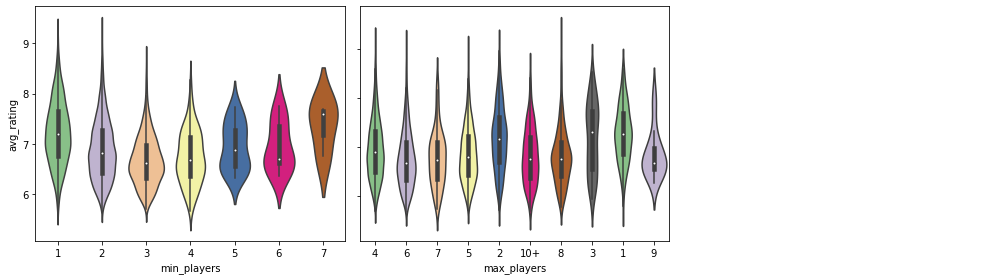

In [69]:
# Plot violinplots for player counts
plot_list = ['min_players', 'max_players']
subplot_violinplot(df, plot_list, 'avg_rating')

As expected, we do not really see any variability between the player counts and the ratings of the board game. It is more like a categorical feature that some people may consider when choosing a game (e.g. someone looking for a party game with a min. player count of 8).

### Complexity

First, we want to check out the missing values.

In [70]:
# Missing values in complexity
df[df['complexity'].isnull()]

bgg_id  \
6877    24209   
13528   72050   
17824  118688   
24332  159333   
25422  165521   
25424  165523   
28700  182952   
29474  188051   
30081  192324   
31453  202096   
32245  208340   
34204  224830   
34283  225303   
35218  231812   
35375  232956   
37363  246693   
37402  246895   
38620  255356   
39362  259435   
39461  260269   
39766  261982   
39767  261984   
40240  265039   
40352  265754   
40693  268098   
40719  268274   
41029  270223   
41143  271036   
41402  273482   
41453  274072   
42799  283474   
43354  286533   
43505  287217   
43535  287345   
43604  287691   
44293  292961   
44294  292962   
44720  295949   
45664  302098   
45707  302312   
45789  302926   
46805  310611   
47176  313473   
47304  314243   
47769  317981   
47784  318098   

                                                                                       name  \
6877                                                                        Kaleidos Junior   
13528                                                                     Freebooter's Fate   
17824                                                                              Sleepers   
24332                                                                                 Fendo   
25422                                                             Rory's Story Cubes: Medic   
25424                                                             Rory's Story Cubes: Score   
28700                                                          Rory's Story Cubes: Animalia   
29474                                                                              Deadfall   
30081                                                          Rory's Story Cubes: Medieval   
31453                             Marvel Dice Masters: Iron Man and War Machine Starter Set   
32245                                              Congo: Adventures in the Heart of Africa   
34204                                                                        Chimera & More   
34283                                                Gamer Over! A Game Fair Murder Mystery   
35218                          Warhammer 40,000: Heroes of Black Reach – Drop Zone Demo Kit   
35375                                                               Omen: Fires in the East   
37363                                                                         Funky Chicken   
37402                                          DC Comics Dice Masters: Justice Campaign Box   
38620                                                                              Werwölfe   
39362  Middle-earth Strategy Battle Game: The Lord of the Rings – Battle of Pelennor Fields   
39461                                                                             Eco-Links   
39766                                                              Combo Fighter: VS Pack 1   
39767                                                              Combo Fighter: VS pack 2   
40240            A Song of Ice & Fire: Tabletop Miniatures Game – Night's Watch Starter Set   
40352                                                 Exceed: Street Fighter – M. Bison Box   
40693                                  Warhammer: The Game of Fantasy Battles (7th Edition)   
40719                                                      Star Trek: Deep Space Nine Fluxx   
41029                                                                    Ab durch die Mauer   
41143                                                                               Pigasus   
41402                A Song of Ice & Fire: Tabletop Miniatures Game – Free Folk Starter Set   
41453                                                               Omen: Heir to the Dunes   
42799                                               Star Wars: Legion – Clone Wars Core Set   
43354                                                                   6 nimmt! Brettspiel   
43505                                                                   

In [71]:
# Distribution of num_votes in entries with missing complexity
df[df['complexity'].isnull()][['rank','num_votes', 'avg_rating', 'bayes_rating']].describe()

rank   num_votes  avg_rating  bayes_rating
count    46.000000   46.000000   46.000000     46.000000
mean   8625.086957   64.500000    7.529958      5.570799
std    1118.798956   24.303406    0.674196      0.022705
min    5900.000000   31.000000    6.332330      5.549260
25%    7934.000000   44.250000    7.022213      5.553742
50%    8982.000000   62.500000    7.519445      5.561750
75%    9578.500000   75.250000    8.031120      5.580120
max    9933.000000  128.000000    8.746150      5.638290

We observe that the board games with missing complexity values are not very popular. Since it also constitute a small proportion (<5%) of the dataset, we choose to drop them.

In [72]:
# Dropping missing value entries for complexity
df = df[df['complexity'].notnull()]

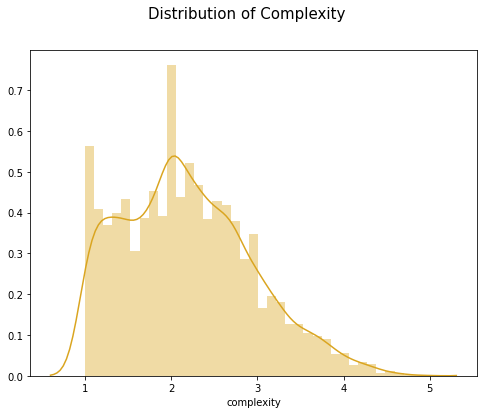

In [73]:
# Plot distribution of complexity
plt.figure(figsize=(8,6))

sns.distplot(df['complexity'], color='goldenrod')
plt.suptitle('Distribution of Complexity', fontsize=15);

As observed in the pairplot above, we still see a high frequency of board games having a lower complexity rating of 1.0 or 2.0.

### Board Game Types

This board game is usually one of the important things which board gamers look out for when selecting the next board game to purchase. We want to look into the high proportions of board games with uncategorized game types.

In [74]:
# View 40 games with missing game types
df[df['game_type'].isnull()].sample(40, random_state=42)

bgg_id  \
6115    21829   
41461  274090   
35049  230860   
34777  229006   
36449  240584   
22121  146207   
41182  271262   
30148  192701   
30003  191986   
15832  100089   
30519  194923   
38331  253756   
32936  214879   
24269  158915   
44320  293141   
40456  266445   
42887  284054   
36725  242667   
39047  257306   
40958  269766   
31885  205544   
43346  286431   
33422  218503   
47677  317105   
34803  229235   
29478  188076   
22118  146197   
37625  248567   
22591  148730   
33878  222424   
14951   90274   
40531  266965   
33433  218576   
33898  222643   
32698  212376   
39310  259038   
30644  195547   
31613  203204   
35255  232090   
42535  281664   

                                                                            name  \
6115                                                                    Sherwood   
41461                                           Lanterns Dice: Lights in the Sky   
35049                                                                       Faza   
34777                                                                     SpyNet   
36449                                                          Blend Coffee Lab.   
22121                                                            Dead Man's Hand   
41182      Advanced Squad Leader: Starter Kit #4 – Pacific Theater of Operations   
30148                                                                Final Touch   
30003                                                                     Rhodes   
15832                                               Inspector Moss: House Arrest   
30519                                     Techno Bowl: Arcade Football Unplugged   
38331                                                              Gorus Maximus   
32936                                                                Tomb Trader   
24269                                                                        GEM   
44320                                                King of Tokyo: Dark Edition   
40456                                                      Sherlock: Propagation   
42887                                                                  Smoothies   
36725                                                  Dark Souls: The Card Game   
39047                                                                 High Score   
40958                                                                  Soulaween   
31885                                                         Rescue Polar Bears   
43346                                                               Electropolis   
33422                                       Wartime: The Battle of Valyance Vale   
47677                                              Tiny Epic Galaxies BLAST OFF!   
34803                                                            Guardian's Call   
29478                                                              Taluva Deluxe   
22118                                           Legends of the American Frontier   
37625                                            Star Trek: Galactic Enterprises   
22591                                                                       Copa   
33878                                                              Planecrafters   
14951                                                Dawn: Rise of the Occulites   
40531                            Dice Throne: Season Two – Tactician v. Huntress   
33433                                                             Fantastic Park   
33898                                                     The Lady and the Tiger   
32698                                                                     Stroop   
39310                                                                   Bastille   
30644                                          LOAD: League of Ancient Defenders   
31613  Magic: The Gathering – Arena of the Planeswalkers: Shadows over Innistrad   
35255                            

In [75]:
# Description for board games with missing game types
df[df['game_type'].isnull()][['rank','num_votes', 'avg_rating', 'bayes_rating']].describe()

rank    num_votes   avg_rating  bayes_rating
count   2895.000000  2895.000000  2895.000000   2895.000000
mean    6526.749914   248.995855     6.917288      5.658691
std     2188.856259   218.085827     0.598765      0.134338
min      804.000000    31.000000     5.707120      5.548440
25%     4831.500000   110.000000     6.469740      5.571270
50%     6728.000000   181.000000     6.831580      5.608540
75%     8374.500000   312.000000     7.272055      5.696000
max    10000.000000  2619.000000     9.200310      6.631710

In [76]:
# View popular games sorted by year
df.loc[(df['game_type'].isnull()) & (df['num_votes']>200)].sort_values(by='year', ascending=False)

bgg_id  \
48058  319966   
44227  292564   
43009  284742   
41237  271754   
43019  284777   
36522  241066   
43267  286160   
35691  235014   
33642  220133   
44320  293141   
42942  284378   
44342  293296   
44367  293531   
44421  293889   
44491  294448   
44502  294514   
44674  295577   
44719  295948   
42968  284584   
41312  272533   
44843  296626   
39029  257193   
41968  277927   
41793  276779   
38876  256513   
38874  256509   
41712  276090   
41689  275974   
42280  280032   
42497  281466   
37194  245658   
42602  282171   
41575  274841   
39437  260180   
42724  282922   
37572  248125   
41448  274037   
41417  273703   
44757  296167   
40541  267009   
44881  296912   
45449  300531   
45551  301255   
45628  301716   
45633  301767   
45021  297895   
45636  301880   
45638  301919   
45675  302193   
45710  302336   
45742  302524   
45781  302809   
45802  303051   
46084  305682   
46126  306040   
46543  308765   
46593  309110   
46595  309113   
46892  311193   
47010  312267   
47202  313698   
47276  314040   
47590  316546   
47843  318553   
47887  318977   
45455  300583   
38995  257001   
45241  299169   
45279  299317   
45039  298060   
45366  299960   
45444  300442   
45100  298371   
45150  298572   
45204  299027   
45428  300300   
45287  299372   
40637  267735   
39242  258412   
39241  258411   
39196  258148   
39165  257987   
40268  265204   
39022  257160   
39015  257096   
39243  258413   
40798  268890   
39004  257063   
40656  267814   
39001  257056   
40633  267652   
40622  267568   
39326  259298   
40212  264925   
40196  264806   
40277  265260   
40111  264321   
40279  265285   
40314  265524   
40418  266177   
40435  266304   
39956  263155   
40462  266460   
39774  262042   
39673  261342   
40465  266504   
40480  266564   
38996  257006   
40616  267475   
39612  261009   
39540  260710   
40083  264196   
37032  244769   
38966  256876   
35734  235451   
36675  242343   
36636  242149   
36505  240957   
36492  240855   
36470  240744   
36249  238916   
36083  237706   
35989  237023   
35893  236305   
35659  234776   
38925  256729   
35512  233896   
35334  232595   
34773  228959   
34362  225910   
31058  198985   
31086  199223   
31324  201006   
33074  216179   
31770  204602   
36879  243993   
36907  244099   
40820  269041   
37063  244946   
38754  255907   
38687  255633   
38675  255594   
38578  255175   
38551  254994   
38327  253743   
38304  253635   
38265  253372   
38244  253215   
38186  252854   
38090  252163   
38048  251723   
37999  251551   
37897  250881   
37767  249746   
37752  249673   
37464  247342   
37344  246535   
25640  166854   
40804  268936   
32445  209641   
40825  269069   
42292  280136   
42289  280132   
42246  279869   
42212  279613   
40836  269160   
43521  287275   
43528  287322   
43588  287607   
42134  279135   
43606  287693   
43617  287742   
42094  278751   
42830  283718   
42028  278297   
43620  287754   
41992  278120   
41923  277597   
41821  276924   
41760  276497   
41688  275973   
41687  275969   
41676  275840   
43650  287938   
41640  275589   
41596  275067   
41591  275034   
43471  287084   
43419  286827   
41547  274638   
43346  286431   
42847  283797   
42872  283934   
42921  284217   
42773  283317   
42769  283289   
42928  284291   
42946  284429   
42754  283211   
42746  283135   
43017  284775   
43092  285157   
42657  282493   
43165  285554   
42652  282463   
42645  282439   
42636  282418   
43192  285773   
43218  285894   
42572  282006   
42565  281960   
42530  281658   
43220  285905   
42401  280896   
42338  280453   
43265  286156   
41586  275010   
42064  278554   
41204  271460   
41156  271060   
44163  292033   
41386  273284   
44164  292034   
41316  272541   
44515  294612   
41296  272438   
41268  272085   
41222  271615   
41211  271519   
41207  271512   
41196  271321   
41150  271044   
41461  274090   
41112  270836   
45227  29912

As suspected, there are many board games published in 2020 which had missing game types although they were trending. Based on domain knowledge, the above listed board games do contain many board games with very good reviews within the board game community. As such, we decide to impute the missing game types with a tag to represent unknown.

In [77]:
# Impute code to represent unknown value
df['game_type'] = df['game_type'].fillna('99999')
ref_dicts['game_types']['99999'] = 'unknown'

In [78]:
# Function to extract frequency of words
def get_top_n_words(corpus, n=None):
    corpus = corpus.astype(str)
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['words', 'count']).set_index('words')

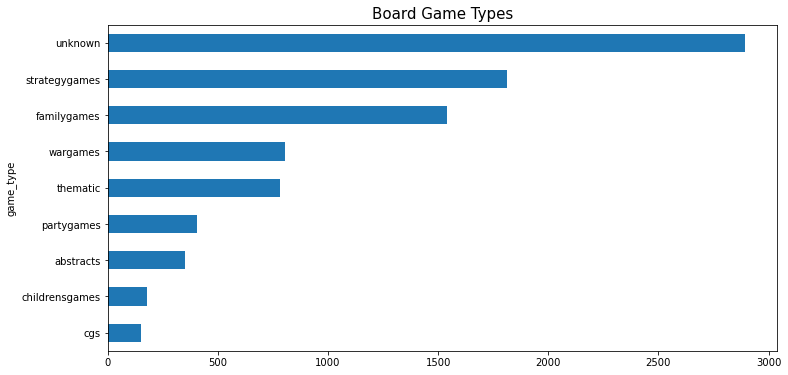

In [79]:
# Convert game_type frequency into dataframe
game_type_freq = get_top_n_words(df['game_type'])
game_type_freq.index = game_type_freq.index.map(ref_dicts['game_types'])

# Visualize board game types using bar plot
game_type_freq.plot(kind='barh', figsize=(12,6))
plt.gca().invert_yaxis()
plt.title('Board Game Types', fontsize=15)
plt.ylabel('game_type')
plt.legend().remove();

Not accounting for the board games with unknown game types, we observe that strategy games make up the main bulk of the board games, closely followed by family games. The proportions of game types are also a good indicator of the current day board game demands, showing that people are generally looking for strategic board games more often than other game types.

### Board Game Categories

Similar to game types, the board game category is also an important feature to look out for in a board game. Different people may have similar tendencies to like certain board game categories.

In [80]:
# View games with missing categories sorted by year
df[df['category'].isnull()].sort_values(by='year', ascending=False)

bgg_id                                                name  year  \
47687  317231                                         Monasterium  2020   
45242  299171                The Key: Raub in der Cliffrock Villa  2020   
41778  276633                                              Rossio  2020   
39406  259857                                      Jurassic Parts  2020   
43795  289081                                  The Grand Carnival  2020   
44283  292894                                            The Cost  2020   
44336  293267                                              Kitara  2020   
44717  295944               Exit: The Game – The Enchanted Forest  2020   
44734  296043                                        Four Gardens  2020   
44834  296557                                          Zen Garden  2020   
45081  298281  EXIT: Das Spiel + Puzzle – Der verschollene Tempel  2020   
45082  298282   EXIT: Das Spiel + Puzzle – Der einsame Leuchtturm  2020   
44719  295948                                             Aqualin  2020   
45243  299172                 The Key: Murder at the Oakdale Club  2020   
45372  300001                                            Renature  2020   
45399  300095                                              Jubako  2020   
45455  300583                                       Village Green  2020   
45467  300683                                         Meeple Land  2020   
45803  303053                                       Last Defense!  2020   
45866  303554                                      Winter Kingdom  2020   
45309  299571                                             Bandida  2020   
47276  314040                           Pandemic Legacy: Season 0  2020   
46390  307656                                            Seastead  2020   
40275  265249                                     Greenville 1989  2019   
40851  269205                                            Overload  2019   
40656  267814                    Adventure Games: Monochrome Inc.  2019   
30977  198517                       Consumption: Food and Choices  2019   
35445  233354                                        Chocolatiers  2019   
40136  264452                                           High Risk  2019   
39785  262114                                   Rival Restaurants  2019   
39316  259081                                   Machi Koro Legacy  2019   
36728  242684                                  Reavers of Midgard  2019   
29668  189453                               Victorian Masterminds  2019   
41324  272599                                      Deadly Doodles  2019   
42565  281960                                     Kingdomino Duel  2019   
41329  272682                               Expedition to Newdale  2019   
42865  283867                                            Offshore  2019   
43865  289601                                         Combo Color  2019   
43606  287693                                             Anubixx  2019   
43177  285627                                 Trapper Keeper Game  2019   
41494  274300                                       Dragon Market  2019   
42895  284082                Adventure Games: The Volcanic Island  2019   
42769  283289                                       ClipCut Parks  2019   
42401  280896                                             Foodies  2019   
41602  275089                                       Mental Blocks  2019   
39832  262388                                             Qwantum  2018   
39440  260201                                            Manitoba  2018   
39002  257058                                          Valparaíso  2018   
38615  255332                                    Vault of Dragons  2018   
37042  244814                                              Embark  2018   
35310  232403                                     Haunt the House  2018   
37037  244795                                  Lost Cities: To Go  2018   
37036  244794                   

In [81]:
# Description for board games with missing categories
df[df['category'].isnull()][['rank','num_votes', 'avg_rating', 'bayes_rating']].describe()

rank    num_votes  avg_rating  bayes_rating
count   109.000000   109.000000  109.000000    109.000000
mean   5742.266055   545.862385    6.874973      5.741838
std    2512.922965  1141.695113    0.571413      0.264438
min     703.000000    42.000000    5.912120      5.549200
25%    3915.000000   133.000000    6.422890      5.586770
50%    5894.000000   209.000000    6.764300      5.638430
75%    7613.000000   470.000000    7.233460      5.771090
max    9952.000000  9420.000000    9.082350      6.707650

The above listed board games do contain many board games with very good reviews within the board game community. As such, we decide to impute the missing categories with a tag to represent unknown.

In [82]:
# Impute code to represent unknown value
df['category'] = df['category'].fillna('99999')
ref_dicts['categories']['99999'] = 'unknown'

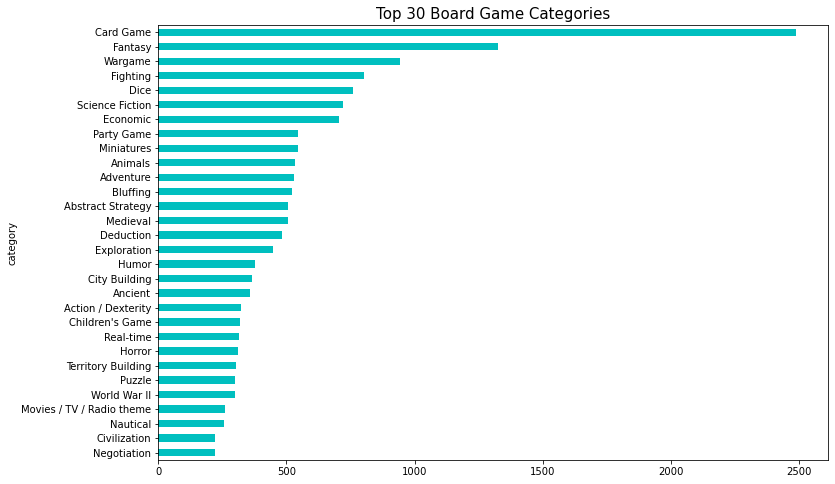

In [83]:
# Convert category frequency into dataframe
category_freq = get_top_n_words(df['category'], 30)
category_freq.index = category_freq.index.map(ref_dicts['categories'])

# Visualize top 30 using bar plot
category_freq.plot(kind='barh', figsize=(12,8), color='c')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Categories', fontsize=15)
plt.ylabel('category')
plt.legend().remove();

We observe that card games, or board games that involves cards, make up the largest percentage of the board games. We then see that Fantasy board games are also apparent in the dataset. Wargames come in third, which is kind of surprising since these category of board games then to be lengthy and harder to bring out onto the game table.

### Mechanics

The board game mechanics is another important feature for board gamers to consider when looking for a new board game.

In [84]:
# View games with missing mechanics sorted by year
df[df['mechanic'].isnull()].sort_values(by='year', ascending=False)

bgg_id  \
47925  319114   
47687  317231   
46916  311322   
46390  307656   
45866  303554   
45243  299172   
45242  299171   
44717  295944   
43489  287158   
42535  281664   
40277  265260   
40527  266938   
41015  270131   
41040  270269   
42670  282530   
42895  284082   
43101  285203   
44254  292748   
38762  255970   
35599  234429   
36874  243964   
37055  244916   
37139  245389   
37557  248002   
37653  248830   
38615  255332   
39639  261145   
38862  256478   
38888  256569   
39044  257284   
39661  261262   
38881  256538   
31458  202204   
31752  204504   
33259  217447   
34021  223726   
33578  219509   
33276  217554   
33137  216658   
33193  217083   
32930  214747   
34435  226322   
32781  213149   
34259  225163   
37351  246571   
34628  227893   
34890  229742   
34924  230059   
35421  233194   
35847  235944   
36671  242325   
34682  228371   
40788  268846   
31543  202737   
31997  206463   
31639  203405   
30420  194234   
28788  183420   
32062  206925   
29843  191065   
29900  191374   
32019  206591   
31498  202477   
32063  206928   
32189  207951   
32509  209886   
32561  210342   
32609  211146   
33002  215455   
36919  244153   
32179  207898   
39824  262341   
27765  177843   
23803  156097   
26347  171136   
26554  172164   
26809  173291   
26977  174093   
27053  174517   
28053  179627   
27937  178940   
28848  183797   
29198  186302   
29602  189030   
29652  189341   
21997  145609   
25314  164760   
25045  163277   
23341  153510   
23682  155322   
11785   57141   
24752  161546   
24753  161547   
23679  155258   
25156  163929   
25562  166276   
25688  167292   
25746  167604   
26037  169436   
25510  165984   
36922  244171   
21887  145014   
20295  134520   
20543  136279   
21179  140594   
21446  142271   
21628  143509   
21789  144506   
20669  137140   
21890  145042   
22517  148381   
22753  149869   
26022  169368   
24228  158751   
21913  145189   
19487  129751   
17781  118452   
17810  118553   
17814  118568   
17827  118695   
19248  128664   
18424  123228   
19517  129946   
19737  130882   
19826  131325   
22297  147194   
16456  107649   
11759   56835   
15034   91425   
15107   92188   
15160   92838   
15677   98529   
15821   99975   
17223  113401   
16665  109657   
16017  102631   
16163  103783   
15962  102144   
15973  102219   
13964   77361   
12944   66851   
12992   67178   
13048   67631   
13790   74233   
10156   39635   
14348   84989   
14381   85243   
14382   85245   
14388   85256   
14857   89575   
10352   40667   
10356   40759   
10419   40941   
21874  144955   
11248   47218   
11656   55756   
11812   57349   
11990   59223   
12593   64735   
12346   63161   
9863    37345   
9941    37931   
10024   38680   
9803    36789   
9959    38062   
9993    38437   
10099   39095   
10136   39406   
10215   40182   
10641   41762   
10642   41763   
7870    27363   
9802    36788   
9097    32149   
8821    30328   
7340    25695   
6165    21985   
6554    23311   
6577    23387   
6776    23935   
6934    24416   
6981    24525   
7128    24996   
7452    26054   
7475    26118   
6433    22864   
7961    27608   
9020    31545   
2910    10244   
6459    22940   
4532    16362   
4584    16538   
4785    17274   
4413    15911   
4474    16177   
5271    19081   
4433    16035   
3231    11412   
5236    18963   
5235    18961   
5406    19537   
5752    20750   
7554    26315   
5843    21022   
6541    23263   
5066    18266   
5209    18881   
10127   39332   
4292    15386   
2704     9439   
3665    13089   
3534    12627   
2742     9606   
5466    19765   
2018     7062   
2066     7239   
10191   39976   
1895     6584   
2146     7576   
2994    10551   
1902     6608   
4918    17705   
3297    11730   
3410    12171   
4172    15000   
2558     8946   
1075     3269   
1546     4980   
1561     5065   
489      1203   
3046    10707   
852      2542   
874      2602   
833      2472   
663      179

In [85]:
# Description for board games with missing mechanics
df[df['mechanic'].isnull()][['rank','num_votes', 'avg_rating', 'bayes_rating']].describe()

rank    num_votes  avg_rating  bayes_rating
count   266.000000   266.000000  266.000000    266.000000
mean   6842.778195   373.345865    6.607623      5.652543
std    2267.511551   653.425898    0.492583      0.156320
min    1047.000000    38.000000    5.771590      5.548450
25%    5074.500000   124.000000    6.209560      5.564372
50%    7284.000000   193.000000    6.570045      5.594435
75%    8799.000000   391.750000    6.862332      5.679775
max    9998.000000  7181.000000    8.121430      6.476490

We decide to impute the missing mechanics with a tag to represent unknown.

In [86]:
# Impute code to represent unknown value
df['mechanic'] = df['mechanic'].fillna('99999')
ref_dicts['mechanics']['99999'] = 'unknown'

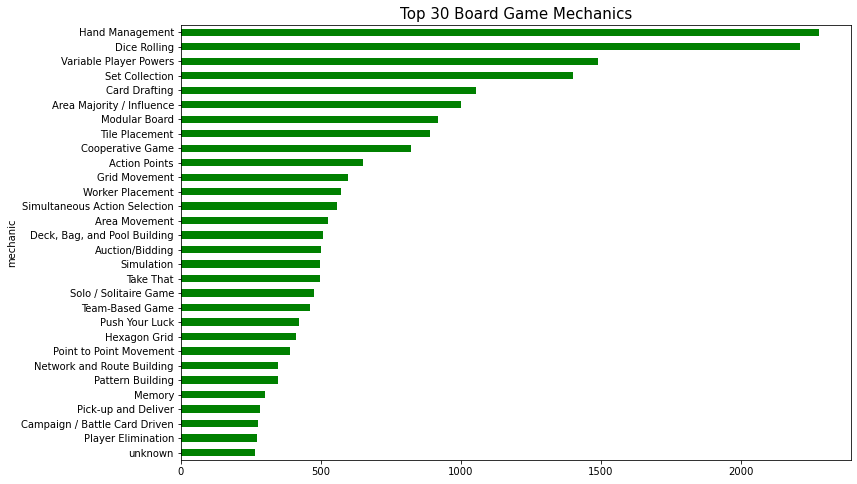

In [87]:
# Convert mechanic frequency into dataframe
mechanic_freq = get_top_n_words(df['mechanic'], 30)
mechanic_freq.index = mechanic_freq.index.map(ref_dicts['mechanics'])

# Visualize top 30 using bar plot
mechanic_freq.plot(kind='barh', figsize=(12,8), color='g')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Mechanics', fontsize=15)
plt.ylabel('mechanic')
plt.legend().remove();

We observe that the highest pecentages of board games have hand management and dice rolling mechanics. Having hand management at the top is synonymous with the top category of board games being card games. Moreover, increasingly popular board games have a higher tendency of including hand/card management based on news of the board game community.  

It is interesting to find the dice rolling mechanic to be a close runner-up the "Dice" category did not appear as high up on the list of top 30 board game categories. It may be due to the fact that including a dice rolling component to a board game is easy, and a board game may still have some dice rolling whilst it is not primarily a dice game.

Variable player powers came in third in the bar chart. It is a board game mechanic which introduces asymmetry into the board game, making each play through different in certain ways. This increases the replayability of board games, which is also why designers are including it in their board games.

Set collection came in fourth in the bar chart. It is a board game mechanic which involves the completion of sets, such as forming a set of four same coloured cards or obtaining items of all types, to gain points essentially. This is no surprise since set collection is a concept very easily understood by people of all ages and backgrounds. It is a mechanic that is simple and yet various strategies could be built to revolve around set collection.

### Designer, Artist, Publisher

While this may not be the most important feature to some, there are indeed some people who look out for board games published by the company, or designed by the same person, or have similar art as the games they love. It is much like watching a movie directed by a famous director, people will be more confident it is going to be good. 

Similarly, for the board games which contain missing values, we want to replace them with tags to represent unknown.

In [88]:
# Impute code to represent unknown value
df['designer'] = df['designer'].fillna('99999')
ref_dicts['designers']['99999'] = 'unknown'

df['artist'] = df['artist'].fillna('99999')
ref_dicts['artists']['99999'] = 'unknown'

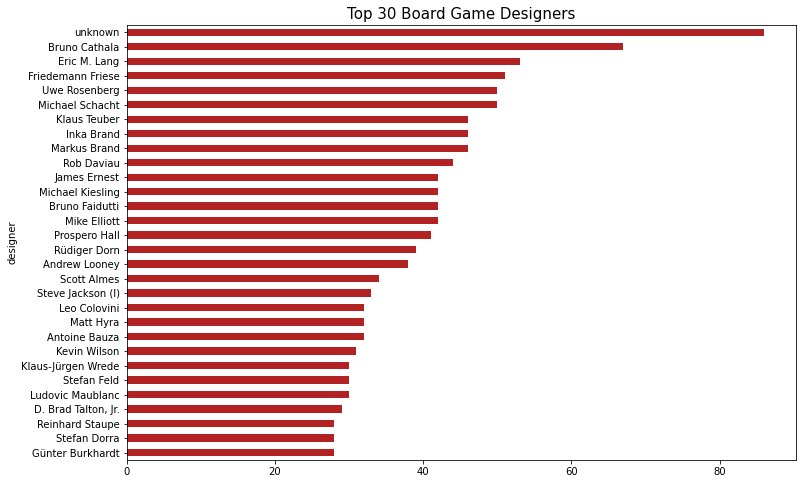

In [89]:
# Convert designer frequency into dataframe
designer_freq = get_top_n_words(df['designer'], 30)
designer_freq.index = designer_freq.index.map(ref_dicts['designers'])

# Visualize top 30 using bar plot
designer_freq.plot(kind='barh', figsize=(12,8), color='firebrick')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Designers', fontsize=15)
plt.ylabel('designer')
plt.legend().remove();

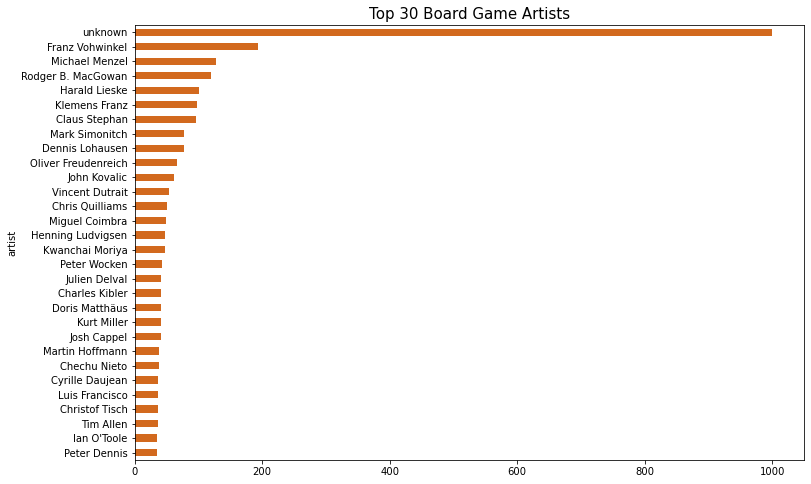

In [90]:
# Convert artist frequency into dataframe
artist_freq = get_top_n_words(df['artist'], 30)
artist_freq.index = artist_freq.index.map(ref_dicts['artists'])

# Visualize top 30 using bar plot
artist_freq.plot(kind='barh', figsize=(12,8), color='chocolate')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Artists', fontsize=15)
plt.ylabel('artist')
plt.legend().remove();

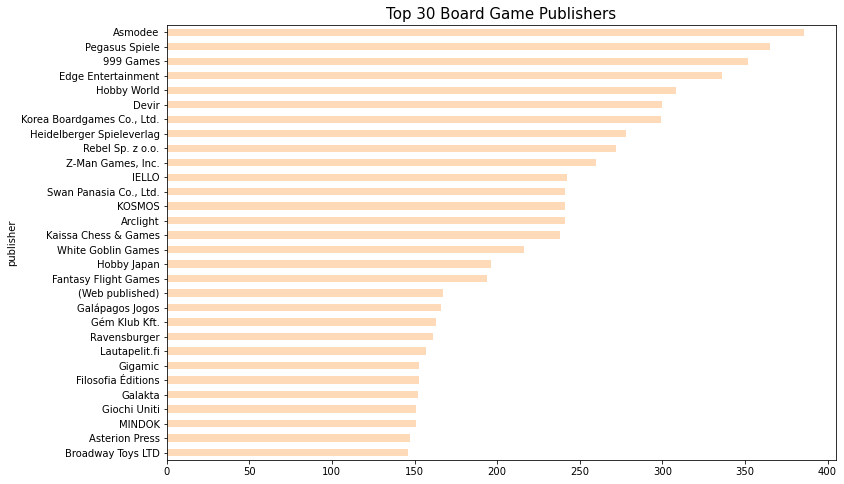

In [91]:
# Convert publisher frequency into dataframe
publisher_freq = get_top_n_words(df['publisher'], 30)
publisher_freq.index = publisher_freq.index.map(ref_dicts['publishers'])

# Visualize top 30 using bar plot
publisher_freq.plot(kind='barh', figsize=(12,8), color='peachpuff')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Publishers', fontsize=15)
plt.ylabel('publisher')
plt.legend().remove();

We see that a high percentage of board games have unknown designers or unknown artists. These could be board games of smaller productions. It is no surprise that Asmodee published the most number of board games, since it is one of the largest publishers and even digitalized many of their board games, further increasing their reputation.

### Cooperative Board Games

The "cooperative" feature could actually be seen as another category or game type. Some people who dislike conflict amongst the players may opt for cooperative board games instead of competitive ones.

In [92]:
df['cooperative'].value_counts()

0    7106
1     823
Name: cooperative, dtype: int64

We observed that there is a much smaller percentage of cooperative board games as compared to competitive ones. It is more difficult to design a cooperative board game, let alone design one that is good. Also, people are generally more competitive against each other when playing any game of sorts, everyone wants to be the sole winner right?

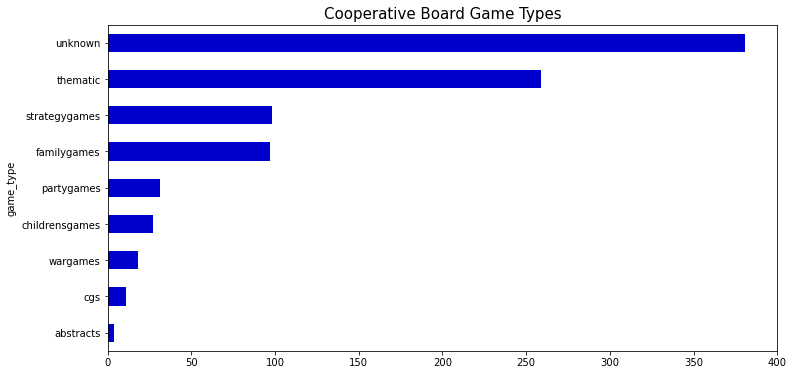

In [93]:
# Game types of the cooperative board games
coop_game_type_freq = get_top_n_words(df.loc[df['cooperative']==1, 'game_type'])
coop_game_type_freq.index = coop_game_type_freq.index.map(ref_dicts['game_types'])

# Visualize board game types using bar plot
coop_game_type_freq.plot(kind='barh', figsize=(12,6), color='mediumblue')
plt.gca().invert_yaxis()
plt.title('Cooperative Board Game Types', fontsize=15)
plt.ylabel('game_type')
plt.legend().remove();

We observe that interestingly, majority of the cooperative board games are categorized as thematic game type, ignoring the unknown ones.

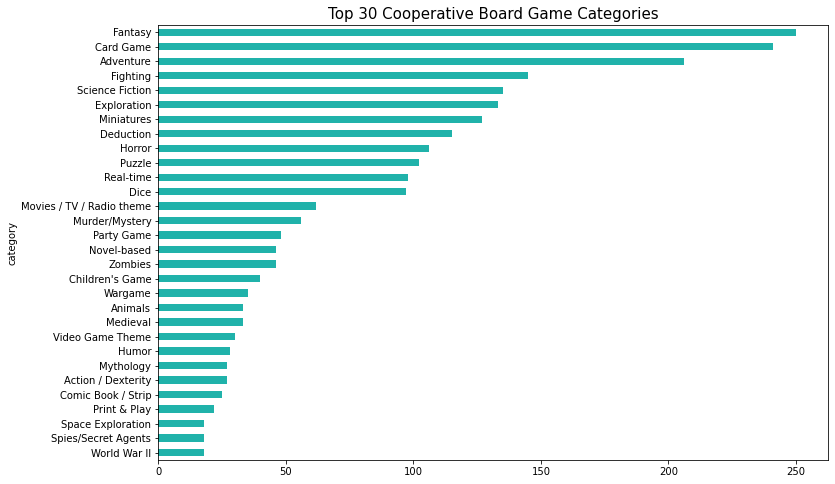

In [94]:
# Categories of cooperative board games
coop_category_freq = get_top_n_words(df.loc[df['cooperative']==1, 'category'], 30)
coop_category_freq.index = coop_category_freq.index.map(ref_dicts['categories'])

# Visualize top 30 words using bar plot
coop_category_freq.plot(kind='barh', figsize=(12,8), color='lightseagreen')
plt.gca().invert_yaxis()
plt.title('Top 30 Cooperative Board Game Categories', fontsize=15)
plt.ylabel('category')
plt.legend().remove();

We observe that the fantasy, adventure, science fiction categories have moved up the charts in cooperative board games.

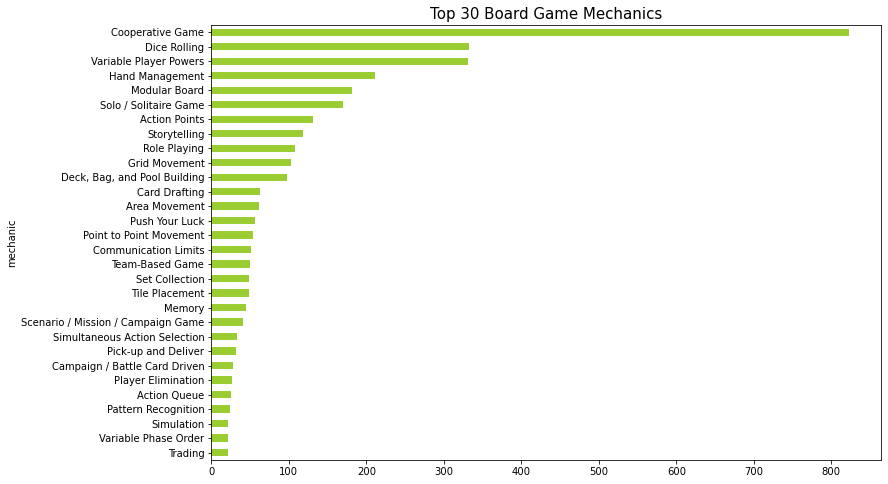

In [95]:
# Mechanics of cooperative board games
coop_mechanic_freq = get_top_n_words(df.loc[df['cooperative']==1, 'mechanic'], 30)
coop_mechanic_freq.index = coop_mechanic_freq.index.map(ref_dicts['mechanics'])

# Visualize top 30 using bar plot
coop_mechanic_freq.plot(kind='barh', figsize=(12,8), color='yellowgreen')
plt.gca().invert_yaxis()
plt.title('Top 30 Board Game Mechanics', fontsize=15)
plt.ylabel('mechanic')
plt.legend().remove();

There is actually a board game mechanic for cooperative games and it is correctly classified for more than 90% of the board games. As such, we do not require the "cooperative" feature anymore since the "mechanic" will be able to explain the same information.

In [96]:
# Drop redundant column
df.drop(columns=['cooperative'], inplace=True)

#### Save objects

In [97]:
# Check for null values
df.isnull().sum()

bgg_id           0
name             0
year             0
game_type        0
designer         0
artist           0
publisher        0
min_players      0
max_players      0
min_age          0
min_time         0
max_time         0
category         0
mechanic         0
rank             0
num_votes        0
avg_rating       0
stddev_rating    0
bayes_rating     0
complexity       0
dtype: int64

In [99]:
# Shape of dataframe
df.shape

(7929, 20)

In [102]:
# Save dataframe into a .pkl file
outfile = open('../datasets/boardgames/clean_bgg_GameItem.pkl', 'wb')
pickle.dump(df.reset_index(drop=True), outfile)
outfile.close()

In [114]:
# Save dictionaries into a .pkl file
outfile = open('../datasets/boardgames/ref_dictionaries.pkl', 'wb')
pickle.dump(ref_dicts, outfile)
outfile.close()